In [3]:
import SimpleITK as sitk # https://simpleelastix.readthedocs.io/

import numpy as np
import scipy as sp
import pandas as pd
from scipy import ndimage
import scipy.interpolate
from scipy.spatial.transform import Rotation as R

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import skimage
import skimage.io
import skimage.transform
import skimage.exposure
import skimage.filters
import skimage.morphology

import tifffile
import nrrd

import re, os, shutil, ast, sys, time, random, gc, math, pickle, time, copy

import anndata

In [4]:
# Functions to display images

# overlay to images to green and magenta
def imageoverlay(imG, imM):
    assert imG.shape == imM.shape
    output = np.zeros(imG.shape + (3,))
    g = skimage.util.img_as_float(imG)
    m = skimage.util.img_as_float(imM)
    output[:,:,0] = m 
    output[:,:,2] = m
    output[:,:,1] = g
    return output

# makes result image have values from 0-1 so it is acceptable to skimage
def scale_result(im):
    return (im - np.min(im))/np.ptp(im)

# adjust the contrast and brightness using percentage of cumulative distribution
def imagescPercent(im, percentlow, percenthigh):
    c , bins = skimage.exposure.cumulative_distribution(im)
    intlow = bins[np.argmin(np.abs(c - percentlow))].astype(im.dtype)
    inthigh = bins[np.argmin(np.abs(c - percenthigh))].astype(im.dtype)
    return skimage.exposure.rescale_intensity(im, in_range = (intlow, inthigh))

def border_transparency(im, RGBval = [1,1,1]):
    im = im/np.amax(im)
    alphas = im > np.amax(im)/5 # the input should have been a single values image anyways...
    rgb = im[:,:,None] * np.array(RGBval)
    return np.concatenate((rgb, alphas[:,:,None]), axis = 2)

# adjust the contrast and brightness using percentage of cumulative distribution
def adjustBC(im, percentlow, percenthigh):
    c , bins = skimage.exposure.cumulative_distribution(im)
    intlow = bins[np.argmin(np.abs(c - percentlow))].astype(im.dtype)
    inthigh = bins[np.argmin(np.abs(c - percenthigh))].astype(im.dtype)
    return skimage.exposure.rescale_intensity(im, in_range = (intlow, inthigh))

# rescale an image size and return uint16
# the preserve range thing here is weird, can it be set to true without the conversion?
def image_rescale(im, factor):
    return skimage.util.img_as_uint(skimage.transform.rescale(im, factor, preserve_range = False))

# fit a list of different sized images into one array
def image_list_to_array(ims):
    size_max = np.amax(np.array([im.shape for im in ims]), axis = 0)
    output = np.zeros([len(ims),size_max[0],size_max[1]], dtype = ims[0].dtype)
    for i,im in enumerate(ims):
        cols, rows = im.shape
        output[i,0:cols,0:rows] = im
    return output

# make some sort of funtion to pre process the data for registration

# gaussian blur
def blur(im, rad = 15):
    return skimage.filters.gaussian(im, rad)

def preprocess(im, thresh_factor = 1, rad = 15):
    edge = skimage.filters.sobel(im)
    thresh = skimage.filters.threshold_otsu(edge)
    return skimage.filters.gaussian(edge > thresh, rad)

def preprocess(im, thresh_factor = 1, rad = 5):
    edge = skimage.filters.sobel(im)
    thresh = skimage.filters.threshold_otsu(edge)
    sel = skimage.morphology.disk(rad)
    output =  blur(skimage.morphology.binary_closing(edge > (thresh * thresh_factor), sel))
    return np.clip(output,0,1)

# binarize an image after blurring and choosing a threshold
def binarize(im, blur_size = 1, thresh_factor = 0.1):
    blurred = blur(im, rad = blur_size) 
    thresh = thresh_factor * skimage.filters.threshold_otsu(blurred)
    return blurred > thresh

def plot_histogram(im, bins = 256, irange = (0,65535)):
    histogram, bin_edges = np.histogram(im, bins=bins, range=irange)
    plt.plot(bin_edges[0:-1], histogram)
    plt.ylim(0,np.amax(histogram[1:]))
    plt.show()

def find_corner(im, area_thresh = 100):
    imB = binarize(im)
    labels = skimage.measure.label(imB)
    rprops = skimage.measure.regionprops(labels)
    rprops = [p for p in rprops if p.area > area_thresh]
    rmin, cmin = np.amin(np.array([p.bbox for p in rprops]), axis = 0)[[0,1]]
    rmax, cmax = np.amax(np.array([p.bbox for p in rprops]), axis = 0)[[2,3]]
    return rmin, cmin, rmax, cmax

# crop an image using the find_corner function
def crop_image(im):
    bbox = find_corner(im)
    return im[bbox[0]:bbox[2], bbox[1]:bbox[3]]

# this will make a test grid the same size as the image
# may be useful to judge how disruptive the transformation is
def make_grid_image(im, grid_size = 220, pix_size = 50):
    dxy = int(grid_size / pix_size)
    output = np.zeros(im.shape)
    for r in range(0, im.shape[0], dxy):
        output[r] = 1
    for c in range(0, im.shape[1], dxy):
        output[:,c] = 1
    return output

def make_grid_image_3D(im, grid_size = 220, pix_size = 50):
    dxy = int(grid_size / pix_size)
    output = np.zeros(im.shape)
    for s in range(0, im.shape[0], dxy):
        output[s] = 1
    for r in range(0, im.shape[1], dxy):
        output[:,r] = 1
    for c in range(0, im.shape[2], dxy):
        output[:,:,c] = 1
    return output

## funtions for transforming points sets
# we have to do some manual transformations to get to the point where we then use the elastix/transformix transforms
# specifically, there is an initial rotation, possible reflection, 

def mat_trans(dx, dy):
    return np.array([[1,0,dx],[0,1,dy],[0,0,1]])

def mat_scale(sx, sy):
    return np.array([[sx,0,0],[0,sy,0],[0,0,1]])

def mat_rot(deg): #2D rotation matrix
    theta = np.deg2rad(deg)
    return np.array([[np.cos(theta),-np.sin(theta),0],[np.sin(theta),np.cos(theta),0],[0,0,1]])

def mat_reflect(reflect = False, dx = 0):
    if reflect:
        return np.array([[-1,0,dx],[0,1,0],[0,0,1]])
    else:
        return np.array([[1,0,0],[0,1,0],[0,0,1]])

    
#adapted from skimage.transform.rotate to account for image size increase
def find_new_corner(rows, cols, deg):

    corners = np.array([
            [0, 0, 1],
            [0, rows - 1, 1],
            [cols - 1, rows - 1, 1],
            [cols - 1, 0, 1]
        ])
    
    # meant for odd numbers? regardless, this is the definition in skimage...
    center = [cols/2 - 0.5, rows/2 - 0.5]
    
    tform1 = mat_trans(-center[0], -center[1])
    tform2 = mat_rot(deg)
    tform3 = mat_trans(center[0], center[1])
    tform = tform3 @ tform2 @ tform1
    #print(corners) # these are the corners before transform
    corners = tform[None, :,:] @ corners[:,:,None]
    #print(corners) # these are the corners after transform
    minc = corners[:, 0].min()
    minr = corners[:, 1].min()
    maxc = corners[:, 0].max()
    maxr = corners[:, 1].max()
    
    out_rows = int(maxr - minr + 1)
    out_cols = int(maxc - minc + 1)
    
    # return the new corners and widths after rotation
    return [minr, minc, out_rows, out_cols]

def transform_positions(tform, array):
    vals = np.concatenate([array,np.ones((len(array),1))], axis = 1)
    out = tform[None,:,:] @ vals[:,:,None]
    return out[:,0:2,0]


# note change to index here
def write_pts_file(array, name = 'points.pts'):
    with open(name, 'w') as f:
        f.write('point\n')
        f.write(str(len(array)) + '\n')
        # write the values in x, y order
        for row in array:
            for r in row:
                f.write(str(r) + ' ')
            f.write('\n')
            
def read_outputpoints_file():
    # the order here is 
    # InputIndex InputPoint OutputIndexFixed OutputPoint Deformation OutputIndexMoving
    with open('outputpoints.txt', 'r') as f:
        lines = f.readlines()
    output = []
    for line in lines:
        columns = line.split('\t;')[1:]
        pairs = [list(map(float, col.split('=')[1].strip(' []\n').split( ))) for col in columns]
        output.append(pairs)
    return np.array(output)

# find the center of the raw image
# do we need to worry about whether the image dimensions are even or odd?
# maybe for large images it doesnt matter since one pixel off will be small
def find_center(im):
    imdim = im.shape
    
    if imdim[0]%2 == 0:
        imcenterr = imdim[0]/2
    else:
        imcenterr = imdim[0]/2 - 0.5

    if imdim[1]%2 == 0:
        imcenterc = imdim[1]/2
    else:
        imcenterc = imdim[1]/2 - 0.5
    
    return np.array([imcenterr,imcenterc])
    
    #return np.array(im.shape).astype(float)/2 - 0.5
    
# define function for parsing using the above regex - make sure it works
def parse_filename(filename, regex = None):
    if regex is None:
        regex = "(?P<sample>.*)_slice(?P<slice>\d)_y_(?P<y1>[-]*\d+)_(?P<y2>[-]*\d+)_x_(?P<x1>[-]*\d+)_(?P<x2>[-]*\d+)_(?P<remainder>.*)"
    pat = re.compile(regex)
    res = pat.match(filename)
    return [res['sample'],int(res['slice']),int(res['y1']),int(res['y2']),int(res['x1']),int(res['x2'])]

## functions for running elastix

def crop_and_pad_image(image1, image2 = None, pad_width = 20, area_thresh = 20):

    bbox = find_corner(image1, area_thresh = area_thresh)
    image1 = np.pad(image1[bbox[0]:bbox[2],bbox[1]:bbox[3]], pad_width)

    if not image2 is None:
        image2 = np.pad(image2[bbox[0]:bbox[2],bbox[1]:bbox[3]], pad_width)

    return bbox, image1, image2

def crop_and_pad_points(pointsXY, bbox, pad_width = 20):
    output_pts = pointsXY - np.array(bbox[1], bbox[0]) # XY order for sitk
    output_pts = output_pts + pad_width
    return output_pts
    
def register_images(fixed_image, moving_image, params_rigid, params_spline = None):
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.LogToFileOn()
    
    elastixImageFilter.SetParameterMap(params_rigid)
    if not params_spline is None:
        elastixImageFilter.AddParameterMap(params_spline)
        
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(fixed_image))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving_image))
    elastixImageFilter.Execute()
    
    result_image = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
    trans = elastixImageFilter.GetTransformParameterMap()
    
    return trans, result_image

def register_images(fixed_image, moving_image, params_rigid, params_spline = None, fixed_mask = None):
    elastixImageFilter = sitk.ElastixImageFilter()
    
    elastixImageFilter.SetOutputDirectory
    
    elastixImageFilter.SetParameterMap(params_rigid)
    if not params_spline is None:
        elastixImageFilter.AddParameterMap(params_spline)
        
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(fixed_image))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving_image))
    
    if 'CorrespondingPointsEuclideanDistanceMetric' in [item for sublist in params_rigid.asdict().values() for item in sublist]:
        print('load corresponding points')
        elastixImageFilter.SetFixedPointSetFileName("fix.pts")
        elastixImageFilter.SetMovingPointSetFileName("mov.pts")
    
    # this is not working
    if not fixed_mask is None:
        mask = sitk.GetImageFromArray(fixed_mask)
        mask = sitk.Cast(mask, sitk.sitkUInt8)
        elastixImageFilter.SetFixedMask(mask)
        print('fixed mask set')
    
    elastixImageFilter.Execute()
    
    result_image = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
    trans = elastixImageFilter.GetTransformParameterMap()
    
    return trans, result_image

def transform_image(moving_image, params, interpolation = True, spacing = None):
    transformixImageFilter = sitk.TransformixImageFilter()
    
    if not interpolation:
        if isinstance(params, tuple):
            for param in params:
                param["ResampleInterpolator"] = L2P(["FinalNearestNeighborInterpolator"])
        else:
            params["ResampleInterpolator"] = L2P(["FinalNearestNeighborInterpolator"])
    
    transformixImageFilter.SetTransformParameterMap(params)

    mov = sitk.GetImageFromArray(moving_image)

    if not spacing is None:
        mov.SetSpacing(spacing)
        print('SITK spacing set to {}'.format(mov.GetSpacing()))
    
    transformixImageFilter.SetMovingImage(mov)
    transformixImageFilter.Execute()
    result = sitk.GetArrayFromImage(transformixImageFilter.GetResultImage())
    return result

#convert a param to a numpy list to do manipulations on it
def P2L(param):
    return np.asarray([float(p) for p in param])

#convert a numpy list to a tuple with strings for the params
def L2P(paramlist):
    strs = [str(p) for p in paramlist]
    return tuple(strs)

def params_from_df(df, num):     
    # make some affine params
    p = sitk.GetDefaultParameterMap("affine")
    p['NumberOfResolutions'] = L2P([4])
    p['MaximumNumberOfIterations'] = L2P([500])
    #p['NumberOfSpatialSamples'] = L2P([4096])
    p['NumberOfHistogramBins'] = L2P([32]) 
    if not np.isnan(df.iloc[num].histogram_bins):
        p['NumberOfHistogramBins'] = L2P([df.iloc[num].histogram_bins])
    # make some spline params
    p2 = sitk.GetDefaultParameterMap("bspline")
    #p2['NumberOfSpatialSamples'] = L2P([32000])
    p2['NumberOfResolutions'] = L2P([4])
    p2['GridSpacingSchedule'] = L2P([20,10,5,2])
    p2['NumberOfHistogramBins'] = L2P([32]) 
    if not np.isnan(df.iloc[num].histogram_bins):
        p2['NumberOfHistogramBins'] = L2P([df.iloc[num].histogram_bins])
    p2['MaximumNumberOfIterations'] = L2P([500])
    if not np.isnan(df.iloc[num].iterations):
        p2['MaximumNumberOfIterations'] = L2P([df.iloc[num].iterations])
    p2['FinalGridSpacingInPhysicalUnits'] = L2P([]) # this remove the param?
    p2['FinalGridSpacingInVoxels'] = L2P([16])
    if not np.isnan(df.iloc[num].spline_grid_size):
        p2['FinalGridSpacingInVoxels'] = L2P([df.iloc[num].spline_grid_size])
        
    # check if there is a csv file with corresponding points...
    
    csv_file = os.path.splitext(df.iloc[num].Filename)[0] + '.csv'
    if os.path.exists(csv_file):
        print('corresponding points file found: {}'.format(csv_file))
        p['Registration'] = L2P(["MultiMetricMultiResolutionRegistration"])
        p['Metric'] = L2P(['AdvancedMattesMutualInformation','CorrespondingPointsEuclideanDistanceMetric'])
        p['Metric0Weight'] = L2P([1 - df.iloc[num].cor_pts_weight])
        p['Metric1Weight'] = L2P([df.iloc[num].cor_pts_weight])
        
        p2['Registration'] = L2P(["MultiMetricMultiResolutionRegistration"])
        p2['Metric'] = L2P(['AdvancedMattesMutualInformation','CorrespondingPointsEuclideanDistanceMetric'])
        p2['Metric0Weight'] = L2P([1 - df.iloc[num].cor_pts_weight])
        p2['Metric1Weight'] = L2P([df.iloc[num].cor_pts_weight])
    
    return p, p2

# importing images from a dataframe
# read the image with some info from a dataframe
def image_from_df(df, index, right_crop = True, scale = True):
    im = skimage.io.imread(df.iloc[index]['Filename'])
    if not np.isnan(df.iloc[index]['rot_init']):
        im = skimage.transform.rotate(im, df.iloc[index]['rot_init'], resize = True)
    if df.iloc[index]['reflect']:
        im = np.flip(im, axis = 1)
    if right_crop:
        if not np.isnan(df.iloc[index]['right_crop']):
            im[:,int(df.iloc[index]['right_crop']):] = 0
    if scale:
        if not (np.isnan(df.iloc[index]['scale_x']) and np.isnan(df.iloc[index]['scale_y'])):
            new_size = im.shape * np.array([df.iloc[index]['scale_y'],df.iloc[index]['scale_x']])
            new_size = new_size.astype(int)
            im = skimage.transform.resize(im, new_size)
    return im

def import_df(path):
    df = pd.read_excel(path)
    df = df.sort_values('z_pos', ignore_index = True)
    
    columns = ['allen_slice_num', 'angle_ZY', 'angle_ZX']    # columns to interpolate
    for col in columns:
        x = df.z_pos.values[np.logical_not(np.isnan(df[col].values))]
        y = df[col].values[np.logical_not(np.isnan(df[col].values))]
        f = scipy.interpolate.interp1d(x, y, kind='linear', fill_value = 'extrapolate')
        df[col] = f(df.z_pos)
    
    df['allen_slice_num'] = df['allen_slice_num'].values.astype(int)
    #
    df['space_modules'] = df['space_modules'].apply(lambda x: ast.literal_eval(str(x)))
    df['cell_types'] = df['cell_types'].apply(lambda x: ast.literal_eval(str(x)))
    df['annots_to_amplify'] = df['annots_to_amplify'].apply(lambda x: ast.literal_eval(str(x)))
    return df

# use the image info dataframe to get some cell metadata from the cell metadata dataframe

def get_cell_metadata_for_slice_index(df, index, cmd, ccf_pixel_size = 25, bbox = None, pad_width = 20):
    file = df.iloc[index].Filename
    rot = df.iloc[index].rot_init
    reflect = df.iloc[index].reflect
    scale_x, scale_y = [df.iloc[index].scale_x, df.iloc[index].scale_y]
    dataname, slicenum, y1, y2, x1, x2 = parse_filename(file)
    # need to know some stuff about the raw image
    imraw = skimage.io.imread(file)
    imdim = np.array(imraw.shape)
    imcenter = find_center(imraw)
    umperpixY = (y2-y1)/imdim[0]
    umperpixX = (x2-x1)/imdim[1]
    
    # here is the cell metadata subset
    cmd_temp = cmd[cmd.sample_id == df.iloc[index].cell_metadata]
    
    tform1 = mat_trans(-x1,-y1) # move the corner of the image to the origin
    tform2 = mat_scale(1/umperpixX, 1/umperpixY) # scale the image into pixels
    tform3 = mat_trans(imcenter[1],imcenter[0]) @ mat_rot(-rot) @ mat_trans(-imcenter[1],-imcenter[0]) # do initial rotation (translated to the center, rotate, translate back)
    shiftr, shiftc, out_rows, out_cols = find_new_corner(imdim[0], imdim[1], -rot) # find the new size of the image since it was rotated
    tform4 = mat_trans(-shiftc,-shiftr) # shift to the new corner
    tform5 = mat_reflect(reflect = reflect, dx = out_cols) # reflect if there is a reflection
    tform6 = mat_scale(scale_x,scale_y) # do final scaling in x and y which was added for better registration
    if bbox is None:
        tform =  tform6 @ tform5 @ tform4 @ tform3 @ tform2 @ tform1 # final transform of everything!
    else:
        tform7 = mat_trans(-bbox[1],-bbox[0]) # crop in on the cells
        tform8 = mat_trans(pad_width,pad_width) # add padding
        tform =  tform8 @ tform7 @ tform6 @ tform5 @ tform4 @ tform3 @ tform2 @ tform1 # final transform of everything!
    
    cells =  cmd_temp[(y1 < cmd_temp['center_y']) &
                      (cmd_temp['center_y'] < y2) & 
                      (x1 < cmd_temp['center_x']) & 
                      (cmd_temp['center_x'] < x2)].copy() # make a copy so it does not give the slice warning...
    
    cells_pos = np.array([cells['center_x'], cells['center_y']]).T
    cells_pos_image_space = transform_positions(tform, cells_pos) # transform the cell positions from the initial transforms
    cells['fixed_x'] = cells_pos_image_space[:,0]
    cells['fixed_y'] = cells_pos_image_space[:,1]
    return cells

# for interactively selecting corresponding points
def onpick(event):
    xmouse = event.mouseevent.xdata
    ymouse = event.mouseevent.ydata
    
    points_cor_x.append(xmouse)
    points_cor_y.append(ymouse)
    
    if len(points_cor_x)%2!=0:
        axs[0].scatter(xmouse, ymouse , marker = 'x', color = 'y', s = 100, linewidth = 3)
        axs[0].annotate(str(math.ceil(len(points_cor_x)/2)), 
                        xy = [xmouse, ymouse], color = 'y', fontsize = 12)
    else:
        axs[1].scatter(xmouse, ymouse , marker = 'x', color = 'y', s = 100, linewidth = 3)
        axs[1].annotate(str(math.ceil(len(points_cor_x)/2)), 
                xy = [xmouse, ymouse], color = 'y', fontsize = 12)
    plt.draw()

In [5]:
# check if elastix is working
elastixImageFilter = sitk.ElastixImageFilter()

In [6]:
%matplotlib inline
#%matplotlib qt

In [7]:
# files

# this excel sheet stores info about the dapi slice images and registration parameters
slice_info_filename = 'WB3_Coronal_1_mosaic_positions_25um_final.xlsx'
# this excel sheet store correspondence between cell types and annotated regions
structure_df_file = r'WB3_co1_cell_types_to_annotations.xlsx'

base_path = os.path.split(os.getcwd())[0]

# subclass color csv file
subclass_color_csv_file = os.path.join(base_path, 'subclass_colors_new.csv')
# allen lut csv file
allen_lut_file = os.path.join(base_path, 'allen lut.csv')
# dictionary mapping allen name to annotation
name_to_annotation_file = os.path.join(base_path, 'allen_name_to_annots.pkl')

# allen nissl and annotation file
ara_nissl_file = os.path.join(base_path, 'ara_nissl_25.nrrd')
ara_annot_file = os.path.join(base_path, 'annotation_25.nrrd')
ara_annot_10_file = os.path.join(base_path, 'annotation_10.nrrd')

# allen border file
# see "allen annotation to border.ipynb"
allen_border_file = os.path.join(base_path, 'annotations_25_border_only.tif')

# cell metadata file
# key columns are center_x, center_y, slice_id, subclass_label_transfer, spatial_modules_level_1
cmd_file = os.path.join(base_path, 'wb3_cell_metadata_cp2_integration_sm1.csv')

# import images from df

In [6]:
# import the excel sheet that has the slice positions, rotations and reflections
# sort depending on the Z value
df = pd.read_excel(slice_info_filename)
df = df.sort_values('z_pos', ignore_index = True)
len(df)

67

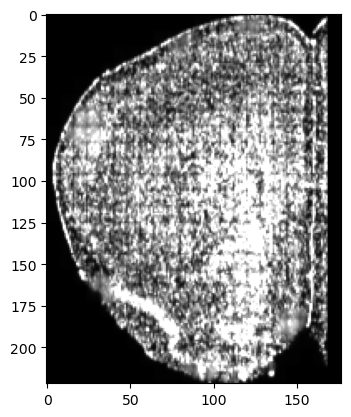

In [7]:
num = 20
plt.imshow(adjustBC(image_from_df(df,num),0,0.9), cmap = 'gray')

### Colormaps

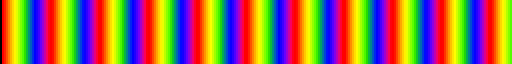

In [8]:
# rainbow colormap
# take the prism colormap and make the zero value black
# turn it into a listed colormap
cmap = cm.prism(np.arange(256))
cmap[0] = [0,0,0,1]
cmap = ListedColormap(cmap)
# set maximum colors to display
max_colors = 1140

cmap

In [9]:
# make an LUT with unique values

def RGB_lut_255(unique_values):
    cmap = (255 * cm.gist_rainbow(np.arange(256))).astype(np.uint8)
    cmap[0] = [0,0,0,1]
    return cmap[np.linspace(0,255,unique_values).astype(int)][:,0:3]

In [8]:
# Allen colormap
df_lut = pd.read_csv(allen_lut_file, names = ['Annotation','R','G','B'])

# make a blank look up table
# this is actually a numpy list
lut = np.zeros([np.amax(df_lut.Annotation) + 1,3], dtype = np.uint8) # add 1 to max value...
# lut needs to be uint8 for RGB
lut.shape

# set the values from the lut
for i,row in df_lut.iterrows():
    lut[row.Annotation] = [row.R,row.G,row.B]

In [9]:
# new subclass colors
temp_df = pd.read_csv(subclass_color_csv_file)
subclass_color = {}
for i, row in temp_df.iterrows():
    subclass_color[row.subclass] = row.color
    
subclass_color['LQ'] = '#ffffff'

# use old DG Glut color
subclass_color['DG Glut'] = '#2bb179'

# Import allen data

In [10]:
#have all of the allen name to annotations at hand

with open(name_to_annotation_file, 'rb') as handle:
    allen_name_to_annots = pickle.load(handle)

len(allen_name_to_annots)

1327

In [11]:
# import nissl

ccf_pixel_size = 25

midline = 228
extra = 8

nissl, header = nrrd.read(ara_nissl_file, index_order='F')
nissl = nissl[:,:,:midline + extra]
print(nissl.shape)

# import annotations
annot, header = nrrd.read(ara_annot_file, index_order='F')
annot = annot[:,:,0:midline + extra]
print(annot.shape)

(528, 320, 236)
(528, 320, 236)


In [14]:
# having some trouble interpolating the annotated image with high values
# hopefully this can shift the values to unused lower values and then shift back the original values
annot_unique = np.unique(annot)

annot_convert = np.zeros(annot_unique[-1] + 1, dtype=np.uint32)
for i,val in enumerate(annot_unique):
    annot_convert[val] = i

annot_revert = np.zeros(len(annot_unique), dtype=np.uint32)
for i,val in enumerate(annot_unique):
    annot_revert[i] = val

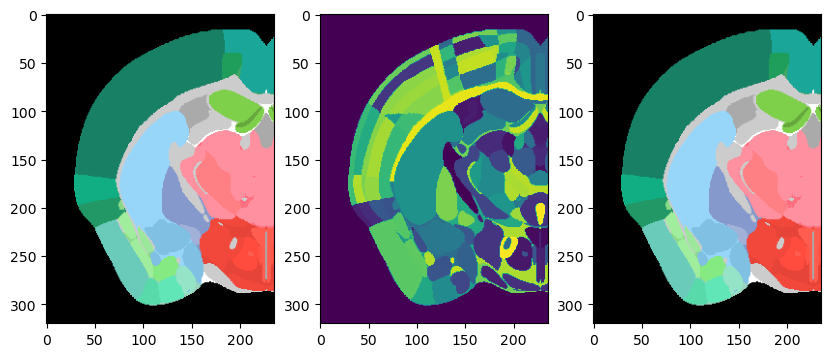

In [15]:
# here is an example
slice_num = 250
fig, axs = plt.subplots(1,3, figsize = (10,5))
axs[0].imshow(lut[annot[slice_num]])
axs[1].imshow(annot_convert[annot[slice_num]])
axs[2].imshow(lut[annot_revert[annot_convert[annot[slice_num]]]])

In [12]:
# import borders
borders = skimage.io.imread(allen_border_file)
borders = borders[:,:,:midline + extra]
print(borders.shape)
print(borders.dtype)

(528, 320, 236)
uint8


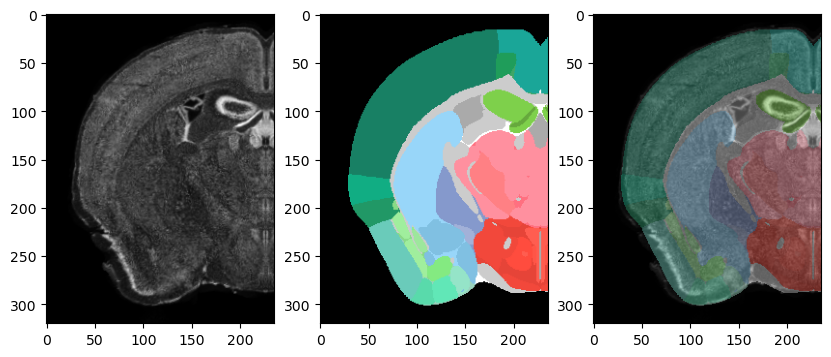

In [17]:
slice_num = 250
fig, axs = plt.subplots(1,3, figsize = (10,5))
axs[0].imshow(nissl[slice_num], cmap = 'gray')
axs[1].imshow(lut[annot[slice_num]])
axs[2].imshow(nissl[slice_num], cmap = 'gray')
axs[2].imshow(lut[annot[slice_num]], alpha = 0.4)

# interpolate allen slices from cut positions

[   0.9450316  -199.09917072]


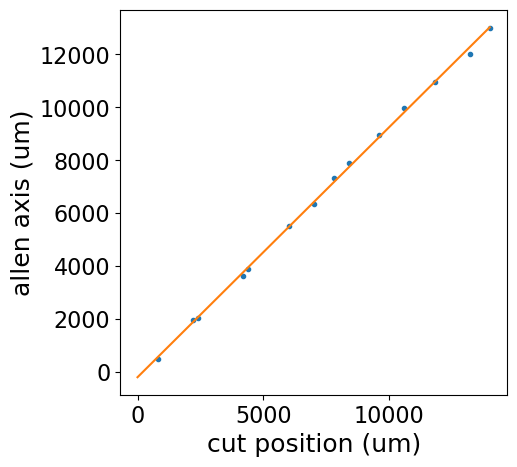

In [18]:
df = pd.read_excel(slice_info_filename)

# sometimes there will be nan values here if we don't fill in this column completely
# can interpolate the values
df.allen_slice_num.values

#####

x = df.z_pos.values[np.logical_not(np.isnan(df.allen_slice_num.values))]

x_slice = df.Slice.values[np.logical_not(np.isnan(df.allen_slice_num.values))]
y = df.allen_slice_num.values[np.logical_not(np.isnan(df.allen_slice_num.values))]

####

um_per_slice_allen = 25

fit = np.polyfit(x, um_per_slice_allen * y, 1)
x_fit = np.arange(np.amax(x))
y_fit = x_fit * fit[0] + fit[1]

print(fit)

fig, axs = plt.subplots(1,1, figsize = (5,5))
fs = 18
axs.plot(x, y * um_per_slice_allen, '.')
axs.plot(x_fit,y_fit)
axs.set_ylabel('allen axis (um)', fontsize=fs)
axs.set_xlabel('cut position (um)', fontsize=fs)
axs.tick_params(axis='both', which='major', labelsize=16)

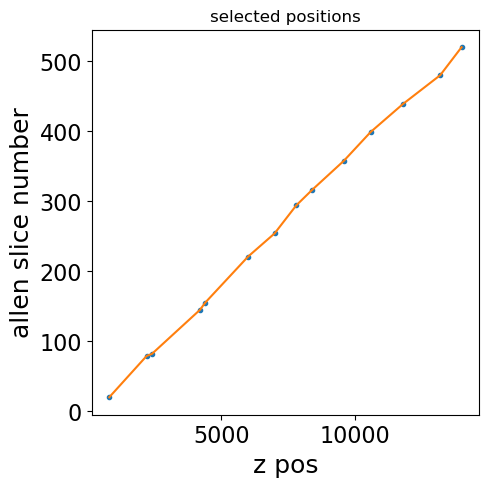

In [19]:
f = scipy.interpolate.interp1d(x, y, kind='linear', fill_value = 'extrapolate')

allen_slice_orig = np.copy(y)
# rewrite the allen slice number with the interpolated version
df.allen_slice_num = f(df.z_pos).astype(int)

fig, axs = plt.subplots(1,1,figsize=(5,5))

axs.set_title('selected positions')
axs.plot(x,allen_slice_orig,'.')
axs.plot(x, f(x))
axs.set_ylabel('allen slice number',fontsize=fs)
axs.set_xlabel('z pos',fontsize=fs)
axs.tick_params(axis='both', which='major', labelsize=16)

In [20]:
# test df importing
df = import_df(slice_info_filename)

# cell metadatas

In [13]:
cmd = pd.read_csv(cmd_file, index_col = 0)
# only take co1 samples
co_samples = cmd.sample_id.str.contains('co1_')
cmd = cmd[co_samples]
cmd.index.rename('cell_id', inplace = True)
len(cmd)

2243099

In [22]:
cmd.columns

Index(['fov', 'volume', 'center_x', 'center_y', 'sample_id', 'slice_id',
       'fov_x', 'fov_y', 'integration_partition_transfer',
       'integration_partition_confidence', 'subclass_label_transfer',
       'subclass_label_confidence', 'cl_transfer', 'cl_confidence',
       'cluster_cosine_similarity', 'adjusted_subclass_label_confidence',
       'adjusted_cl_confidence', 'spatial_modules_level_1', 'sm1_color',
       'local_color', 'spatial_modules_level_1_name', 'sm1n_color'],
      dtype='object')

In [23]:
cmd['lvl2_colors'] = cmd.subclass_label_transfer.map(subclass_color)
# handle no subclass
cmd.loc[cmd.subclass_label_transfer.isna(), 'lvl2_colors'] = subclass_color['LQ']                                            

In [24]:
# use the image info dataframe to get some cell metadata from the cell metadata dataframe

def get_cell_metadata_for_slice_index(df, index, cmd, ccf_pixel_size = 25, bbox = None, pad_width = 20):
    file = df.iloc[index].Filename
    rot = df.iloc[index].rot_init
    reflect = df.iloc[index].reflect
    scale_x, scale_y = [df.iloc[index].scale_x, df.iloc[index].scale_y]
    dataname, slicenum, y1, y2, x1, x2 = parse_filename(file)
    # need to know some stuff about the raw image
    imraw = skimage.io.imread(file)
    imdim = np.array(imraw.shape)
    imcenter = find_center(imraw)
    umperpixY = (y2-y1)/imdim[0]
    umperpixX = (x2-x1)/imdim[1]
    
    # here is the cell metadata subset
    cmd_temp = cmd[cmd.sample_id == df.iloc[index].cell_metadata]
    
    tform1 = mat_trans(-x1,-y1) # move the corner of the image to the origin
    tform2 = mat_scale(1/umperpixX, 1/umperpixY) # scale the image into pixels
    tform3 = mat_trans(imcenter[1],imcenter[0]) @ mat_rot(-rot) @ mat_trans(-imcenter[1],-imcenter[0]) # do initial rotation (translated to the center, rotate, translate back)
    shiftr, shiftc, out_rows, out_cols = find_new_corner(imdim[0], imdim[1], -rot) # find the new size of the image since it was rotated
    tform4 = mat_trans(-shiftc,-shiftr) # shift to the new corner
    tform5 = mat_reflect(reflect = reflect, dx = out_cols) # reflect if there is a reflection
    tform6 = mat_scale(scale_x,scale_y) # do final scaling in x and y which was added for better registration
    if bbox is None:
        tform =  tform6 @ tform5 @ tform4 @ tform3 @ tform2 @ tform1 # final transform of everything!
    else:
        tform7 = mat_trans(-bbox[1],-bbox[0]) # crop in on the cells
        tform8 = mat_trans(pad_width,pad_width) # add padding
        tform =  tform8 @ tform7 @ tform6 @ tform5 @ tform4 @ tform3 @ tform2 @ tform1 # final transform of everything!
    
    cells =  cmd_temp[(y1 < cmd_temp['center_y']) &
                      (cmd_temp['center_y'] < y2) & 
                      (x1 < cmd_temp['center_x']) & 
                      (cmd_temp['center_x'] < x2)].copy() # make a copy so it does not give the slice warning...
    
    cells_pos = np.array([cells['center_x'], cells['center_y']]).T
    cells_pos_image_space = transform_positions(tform, cells_pos) # transform the cell positions from the initial transforms
    cells['fixed_x'] = cells_pos_image_space[:,0]
    cells['fixed_y'] = cells_pos_image_space[:,1]
    return cells

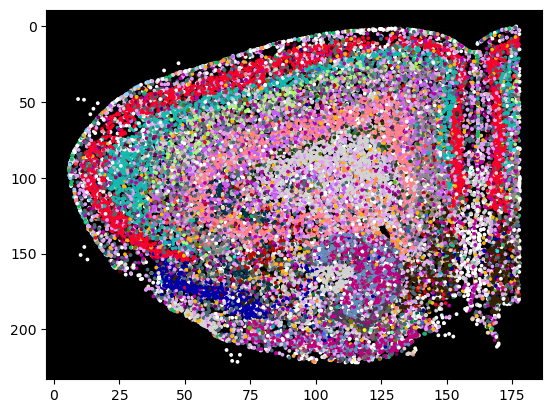

In [25]:
num = 20
cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = 25)

plt.figure()
#fixed = imagescPercent(image_from_df(df, num), 0, 0.9)
#plt.imshow(fixed, cmap = 'gray')
plt.gca().set_facecolor((0,0,0))
plt.scatter(cells['fixed_x'], cells['fixed_y'], s = 3, c = cells.lvl2_colors)
plt.gca().invert_yaxis()

In [26]:
# lets make a place to store the raw cell metatdata
cmd_orig = cmd.copy()
len(cmd_orig)

2243099

# modify nissl

In [27]:
annots_to_amplify = [507, 698, 665, 538, 900] + [632]
annots_to_amplify = annots_to_amplify + allen_name_to_annots['Isocortex']

In [28]:
# make certain regions of nissl have more contrast

def modify_nissl(nissl, annot, factor = 10, annot_dict = None, midline = 228):
    output = np.copy(nissl)
    mean_val = np.mean(output[output > 0])
    annot = np.rint(annot).astype(np.int32)

    # vlmc layer
    mask = annot > 0
    output = output * mask # clear outside the annotation
    
    surface = np.logical_xor(mask, skimage.morphology.binary_dilation(mask, skimage.morphology.disk(2)))
    output[surface] = mean_val * factor # add vlmc
    
    # vlmc layer at SM_CTX/olf
    mask = np.isin(annot, allen_name_to_annots['Isocortex'])
    surface = np.logical_xor(mask, skimage.morphology.binary_dilation(mask, skimage.morphology.disk(2)))    
    output[surface] = mean_val * factor # add vlmc
    
    # vlcm at midline
    mask_ctx = np.isin(annot, allen_name_to_annots['Cerebral cortex'] + allen_name_to_annots['olfactory nerve layer of main olfactory bulb'])
    mask_midline = np.zeros(annot.shape, dtype = bool)
    mask_midline[:,midline-1:midline + 2] = True
    mask_midline = np.logical_and(mask_ctx, mask_midline)
    output[mask_midline] = mean_val * factor

    
    # Ependymal NN
    #annots_ENN = [73, 81, 89, 98, 108, 116, 124, 129, 140, 145, 153, 164]
    annots_ENN = [81,129]
    ventrical_mask = np.isin(annot, annots_ENN)
    edge_mask = np.logical_xor(ventrical_mask, skimage.morphology.binary_erosion(ventrical_mask, skimage.morphology.disk(2)))
    
    output[ventrical_mask] = 0 # remove ventricals
    output[edge_mask] = mean_val * factor # add surface
    
    
    if not annot_dict is None:
        for val in annot_dict:
            mask = (annot == val)
            output += mask * mean_val * factor
            
    return output

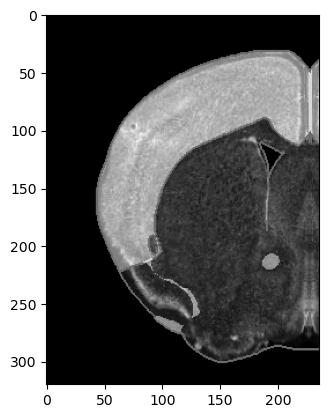

In [29]:
allen_slice_num = 200

output = modify_nissl(
                nissl[allen_slice_num],
                annot[allen_slice_num],
                annot_dict = annots_to_amplify,
                factor = 2)

fig, axs = plt.subplots(1,1)
axs.imshow(output, cmap = 'gray')

# modify dapi

In [30]:
cell_types_to_amplify = ['VLMC NN', 'Ependymal NN', 'CHOR NN', 'Tanyctye NN']
cell_types_to_amplify = cell_types_to_amplify + ['ABC NN', 'Astroependymal NN'] + ['DG Glut']

mob_cells = [
'MOB Dopa-Gaba',
'MOB Eomes Ms4a15 Glut',
'MOB Meis2 Gaba',
'MOB Trdn Gaba',
'MOB-STR-CTX Inh IMN',
'MOB-in Frmd7 Gaba',
'MOB-mi Frmd7 Gaba',
'MOB-out Frmd7 Gaba',
'IT AON-TT-DP Glut']

cell_types_to_amplify = cell_types_to_amplify + mob_cells

In [31]:
# make certain regions of the dapi have more contrast using cell type information 

def modify_dapi(df, num, cmd, cell_types = None, space_modules = None, ccf_pixel_size = 25, factor = 10):
    dapi = image_from_df(df, num)
    cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size)
    
    mean_val = np.mean(dapi[dapi > 0])
    
    ymax,xmax = dapi.shape
    mask = np.zeros(dapi.shape)
    
    cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size)
    x = np.round(cells.fixed_x).astype(int)
    y = np.round(cells.fixed_y).astype(int)
    
    cond = ((x > 0) & (x < (xmax -1)) &
            (y > 0) & (y < (ymax -1)))
    cells = cells[cond]
    
    # enhance cell types
    if not cell_types is None:
        mask2 = np.zeros(dapi.shape)
        df_temp = cells[cells.subclass_label_transfer.isin(cell_types)]
        x = np.round(df_temp.fixed_x).astype(int)
        y = np.round(df_temp.fixed_y).astype(int)
        mask2[y,x] = mean_val * factor
        mask2 = skimage.filters.gaussian(mask2, sigma = 1)
        dapi += mask2
        
    # enhance space modules
    if not space_modules is None:
        mask2 = np.zeros(dapi.shape)
        df_temp = cells[cells.spatial_modules_level_1_name.isin(space_modules)]
        x = np.round(df_temp.fixed_x).astype(int)
        y = np.round(df_temp.fixed_y).astype(int)
        mask2[y,x] = mean_val * factor
        mask2 = skimage.filters.gaussian(mask2, sigma = 1)
        dapi += mask2
    
    #mask = skimage.morphology.binary_dilation(mask, skimage.morphology.disk(1))
    #dapi += mask * mean_val * factor 
    
    # remove any modifications after 'right crop'
    if not np.isnan(df.iloc[num]['right_crop']):
        rc = df.iloc[num]['right_crop']
        sx = df.iloc[num]['scale_x']
        rc_new = int(np.round(rc * sx))
        dapi[:,rc_new:] = 0
    
    return dapi

103


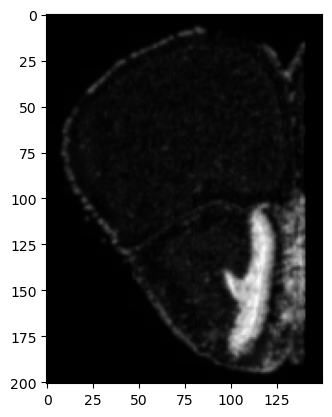

In [32]:
slice_num = 15
num = slice_num-1

df = import_df(slice_info_filename)
print(df.iloc[num].allen_slice_num)

dapi_mod = modify_dapi(df, num, cmd,
                             cell_types = df.iloc[num].cell_types,
                             factor = 10)
fig, axs = plt.subplots(1,1)
axs.imshow(dapi_mod, cmap = 'gray', vmin = 0)

# 2D Registration

### Test registration with corresponding points

In [61]:
%matplotlib qt

In [62]:
# test the registration of a slice
# parameters for registration are stored in the slice_info_filename
# an interactive popup window will appear
# alternately click on left image then right image to record corresponding points
# run the following cell to save a csv file
# the code will automatically find a csv file if it is present

In [68]:
slice_to_register = 25
print('slice to register {}'.format(slice_to_register))

num = slice_to_register - 1

df = import_df(slice_info_filename)
ccf_pixel_size = 25

filename = df.iloc[num].Filename
allen_slice_num = df.iloc[num].allen_slice_num

rescale_percent = 0.99

moving_annot = annot[allen_slice_num]
moving_borders = borders[allen_slice_num]
nissl_im = nissl[allen_slice_num]

print('nissl factor {}'.format(df.iloc[num].nissl_enhance_factor))
print('dapi factor {}'.format(df.iloc[num].dapi_enhance_factor))

fixed = modify_dapi(df, num, cmd,
    cell_types = df.iloc[num].cell_types,
    space_modules = df.iloc[num].space_modules,
    factor = df.iloc[num].dapi_enhance_factor)

moving  = modify_nissl(nissl_im, moving_annot,
    annot_dict = df.iloc[num].annots_to_amplify,
    factor = df.iloc[num].nissl_enhance_factor)

pad_width = 20

# crop images (may not be necessary since we did it already) and add a pad
fix_bbox, fixed, _ = crop_and_pad_image(fixed, pad_width = pad_width, area_thresh = 300)
_, _, moving_borders = crop_and_pad_image(moving, moving_borders, pad_width = pad_width, area_thresh = 300) # be careful here don't overwrite the original moving...
mov_bbox, moving, moving_annot = crop_and_pad_image(moving, moving_annot, pad_width = pad_width, area_thresh = 300) 

cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size, bbox = fix_bbox, pad_width = pad_width)

fig, axs = plt.subplots(1,2)
axs[0].imshow(fixed, cmap = 'gray', picker=True)
axs[0].set_facecolor((0,0,0))
axs[0].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.3, c = cells.lvl2_colors)

#axs[1].imshow(lut[moving_annot],  picker=True)
axs[1].imshow(moving,  picker=True)
axs[1].imshow(moving_borders, alpha = 0.5, cmap = 'gray')

fig.suptitle(filename)

points_cor_x = []
points_cor_y = []

fig.canvas.mpl_connect('pick_event', onpick)

slice to register 25
nissl factor 5
dapi factor 10


14

In [214]:
# if this cell is run, the points will be saved (or overwritten)
filename_csv = os.path.splitext(filename)[0] + '.csv'

df_points = pd.DataFrame()
df_points['fix_x'] = np.array(points_cor_x)[::2]
df_points['fix_y'] = np.array(points_cor_y)[::2]
df_points['mov_x'] = np.array(points_cor_x)[1::2]
df_points['mov_y'] = np.array(points_cor_y)[1::2]

df_points.to_csv(filename_csv, index=False)

print(filename_csv)
df_points

220414_wb3_co1_18B_6z18R_merfish5_slice2_y_-002918_002104_x_-001916_003506_25um_pix.csv


,fix_x,fix_y,mov_x,mov_y
0,201.673933,271.294480,208.406810,268.176382
1,201.673933,35.463272,208.406810,37.839882
2,204.834150,76.546095,208.406810,83.594331
3,206.019231,127.504598,208.797873,137.561117
4,121.483421,91.952154,130.585140,83.985395
5,94.621575,61.140036,103.601747,73.035612


In [67]:
# make some params
p, p2 = params_from_df(df, num)
# crop and pad images

csv_file = os.path.splitext(filename)[0] + '.csv'
if os.path.exists(csv_file):
    print('corresponding points found')
    cor_points = pd.read_csv(csv_file)
    fix_points = cor_points[['fix_x', 'fix_y']].values
    mov_points = cor_points[['mov_x', 'mov_y']].values
    
    write_pts_file(fix_points, name = 'fix.pts')
    write_pts_file(mov_points, name = 'mov.pts')

print('slice num {}'.format(df.iloc[num].Slice))
print('allen slice {}'.format(allen_slice_num))
print('registering in progress')

# register a slice to allen
trans, moving_spline = register_images(fixed, moving, p, p2)

# transform other images
moving_rigid = transform_image(moving, trans[0])
moving_annot_rigid = annot_revert[transform_image(annot_convert[moving_annot], trans[0], interpolation = False).astype(np.uint32)]
moving_annot_spline = annot_revert[transform_image(annot_convert[moving_annot], trans, interpolation = False).astype(np.uint32)]
moving_borders_spline = transform_image(moving_borders, trans, interpolation = True)

# get some cell positions
if True:
    cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size, bbox = fix_bbox)
    
    cells_pos_fixed = np.array([cells['fixed_x'], cells['fixed_y']]).T
    write_pts_file(cells_pos_fixed) # write the files to the disk

    # warp the points
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetTransformParameterMap(trans)
    transformixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving))
    transformixImageFilter.SetFixedPointSetFileName('points.pts')
    transformixImageFilter.Execute()
    output_points = read_outputpoints_file()
    cells_pos_moving = output_points[:,3]
    cells_pos_moving -= pad_width # remove the pad
    cells_pos_moving += np.array([mov_bbox[1], mov_bbox[0]]) # adjust for moving crop

    zloc = np.ones(len(cells_pos_moving)) * allen_slice_num
    yloc = cells_pos_moving[:,1]
    xloc = cells_pos_moving[:,0]
    
    zloc_int = zloc.astype(int)
    yloc_int = yloc.astype(int)
    xloc_int = xloc.astype(int)
    
    z_valid = ((zloc_int > 0) & (zloc_int < annot.shape[0]))
    y_valid = ((yloc_int > 0) & (yloc_int < annot.shape[1]))
    x_valid = ((xloc_int > 0) & (xloc_int < annot.shape[2]))
    valid = z_valid & y_valid & x_valid

    cells_annotations = annot[zloc_int[valid], yloc_int[valid], xloc_int[valid]]

    ccfx = ccf_pixel_size * zloc[valid] # AP axis
    ccfy = ccf_pixel_size * yloc[valid] #
    ccfz = ccf_pixel_size * xloc[valid] #
    
    index_valid = cells.index[valid]
    cmd.loc[index_valid,'ccfx'] = ccfx
    cmd.loc[index_valid,'ccfy'] = ccfy
    cmd.loc[index_valid,'ccfz'] = ccfz
    cmd.loc[index_valid,'annotation'] = cells_annotations # only assign value annotations
    
# try to get annotations from warped annotated image
if True:
    cells_pos_fixed = np.array([cells['fixed_x'], cells['fixed_y']]).T
    cells_pos_fixed_int = cells_pos_fixed.astype(int)

    cells_pos_fixed_select = (
         (cells_pos_fixed_int[:,1] < (moving_annot_spline.shape[0] - 1)) &
         (cells_pos_fixed_int[:,1] >= 0) &
         (cells_pos_fixed_int[:,0] < (moving_annot_spline.shape[1] - 1)) &
         (cells_pos_fixed_int[:,0] >= 0))
    cells_pos_fixed_int = cells_pos_fixed_int[cells_pos_fixed_select]
    cells_pos_fixed_annotations = moving_annot_spline[cells_pos_fixed_int[:,1],cells_pos_fixed_int[:,0]].astype(int)

    
### This is plotting to compare cells positions to borders ###

color_map = 'lvl2_colors'

percent_high = 0.95

fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize = (10,7))
fig.suptitle('slice {} to allen {}'.format(df.iloc[num].Slice, allen_slice_num), fontsize=16)

axs[0,0].set_title('fixed slice {}'.format(df.iloc[num].Slice))
axs[0,0].imshow(imagescPercent(fixed,0, percent_high), cmap = 'gray')
#axs[0,0].scatter(cells['fixed_x'], cells['fixed_y'])

axs[0,1].set_title('fixed + rigid')
axs[0,1].imshow(
    imageoverlay(
    imagescPercent(scale_result(fixed),0.0, percent_high),
    imagescPercent(scale_result(moving_rigid),0.0,percent_high)
            ))

axs[0,2].set_title('fixed + spline')
axs[0,2].imshow(
    imageoverlay(
    imagescPercent(scale_result(fixed),0.0, percent_high),
    imagescPercent(scale_result(moving_spline),0.0,percent_high)
            ))

axs[0,3].set_title('fixed + borders spline')
axs[0,3].imshow(imagescPercent(fixed,0, percent_high), cmap = 'gray')
axs[0,3].imshow(border_transparency(moving_borders_spline, RGBval = [1,0,1]))

axs[1,0].set_title('moving allen {}'.format(allen_slice_num))
axs[1,0].imshow(imagescPercent(moving,0, percent_high), cmap = 'gray')

axs[1,1].set_title('moving rigid')
axs[1,1].imshow(imagescPercent(moving_rigid,0, percent_high), cmap = 'gray')

axs[1,2].set_title('moving spline')
axs[1,2].imshow(imagescPercent(moving_spline,0, percent_high), cmap = 'gray')

axs[2,0].set_title('borders')
axs[2,0].set_facecolor((0,0,0))
axs[2,0].imshow(border_transparency(moving_borders, RGBval = [1,0,1]))

axs[2,1].set_title('moving + borders')
axs[2,1].imshow(imagescPercent(moving,0, percent_high), cmap = 'gray')
axs[2,1].imshow(border_transparency(moving_borders, RGBval = [1,0,1]))

axs[2,2].set_title('moving + borders spline')
axs[2,2].imshow(imagescPercent(moving_spline,0, percent_high), cmap = 'gray')
axs[2,2].imshow(border_transparency(moving_borders_spline, RGBval = [1,0,1]))

# all cells
fig3, axs = plt.subplots(1,2, figsize = (15,10))

axs[0].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))

axs[1].set_title('slice {}'.format(slice_to_register))
axs[1].set_facecolor((1,1,1))
axs[1].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.3, c = cells[color_map])
axs[1].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))
print('done')

corresponding points file found: 220408_wb3_co1_8B_6z19R_merfish5_slice0_y_-003749_001274_x_-002699_002524_25um_pix.csv
corresponding points found
slice num 23
allen slice 163
registering in progress
load corresponding points
done


# Loop through slices

In [72]:
istart = 4 #4
istop = 58 #58
rescale_percent = 0.99

In [73]:
matplotlib.use('Agg')

plotQ = True

# Do a loop of a bunch of slices
slices_to_register = np.arange(istart,istop).astype(int)

for slice_to_register in slices_to_register:
    
    print('working on slice {}'.format(slice_to_register))
    
    # Do a big loop to test many registration angles of this slice
    num = slice_to_register - 1

    df = import_df(slice_info_filename)
    
    ccf_pixel_size = 25

    print('{}/{}'.format(slice_to_register,slices_to_register[-1]), end = '\r')

    filename = df.iloc[num].Filename
    allen_slice_num = df.iloc[num].allen_slice_num

    rescale_percent = 0.99

    moving_annot = annot[allen_slice_num]
    moving_borders = borders[allen_slice_num]
    nissl_im = nissl[allen_slice_num]

    fixed = modify_dapi(df, num, cmd,
        cell_types = df.iloc[num].cell_types,
        space_modules = df.iloc[num].space_modules,
        factor = df.iloc[num].dapi_enhance_factor)

    moving  = modify_nissl(nissl_im, moving_annot,
        annot_dict = df.iloc[num].annots_to_amplify,
        factor = df.iloc[num].nissl_enhance_factor)

    # make some params
    p, p2 = params_from_df(df, num)
    # crop and pad images
    pad_width = 20
    # crop images (may not be necessary since we did it already) and add a pad
    fix_bbox, fixed, _ = crop_and_pad_image(fixed, pad_width = pad_width, area_thresh = 300)
    _, _, moving_borders = crop_and_pad_image(moving, moving_borders, pad_width = pad_width, area_thresh = 300) # be careful here don't overwrite the original moving...
    mov_bbox, moving, moving_annot = crop_and_pad_image(moving, moving_annot, pad_width = pad_width, area_thresh = 300) 
    
    # check if there are corresponding points
    csv_file = os.path.splitext(filename)[0] + '.csv'
    if os.path.exists(csv_file):
        print('corresponding points found')
        cor_points = pd.read_csv(csv_file)
        fix_points = cor_points[['fix_x', 'fix_y']].values
        mov_points = cor_points[['mov_x', 'mov_y']].values

        write_pts_file(fix_points, name = 'fix.pts')
        write_pts_file(mov_points, name = 'mov.pts')
    
    # register a slice to allen
    trans, moving_spline = register_images(fixed, moving, p, p2)

    # transform other images
    moving_rigid = transform_image(moving, trans[0])
    moving_annot_rigid = annot_revert[transform_image(annot_convert[moving_annot], trans[0], interpolation = False).astype(np.uint32)]
    moving_annot_spline = annot_revert[transform_image(annot_convert[moving_annot], trans, interpolation = False).astype(np.uint32)]
    moving_borders_spline = transform_image(moving_borders, trans, interpolation = True)   
    
    # get some cell positions
    cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size, bbox = fix_bbox)
    
    # only proceed if we have some cell metadata
    if len(cells) > 0:

        cells_pos_fixed = np.array([cells['fixed_x'], cells['fixed_y']]).T #
        write_pts_file(cells_pos_fixed) # write the files to the disk

        # warp the points
        transformixImageFilter = sitk.TransformixImageFilter()
        transformixImageFilter.SetTransformParameterMap(trans)
        transformixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving))
        transformixImageFilter.SetFixedPointSetFileName('points.pts')
        transformixImageFilter.Execute()

        output_points = read_outputpoints_file()

        cells_pos_moving = output_points[:,3]

        cells_pos_moving -= pad_width # remove the pad
        cells_pos_moving += np.array([mov_bbox[1], mov_bbox[0]]) # adjust for moving crop

        zloc = np.ones(len(cells_pos_moving)) * allen_slice_num
        yloc = cells_pos_moving[:,1]
        xloc = cells_pos_moving[:,0]

        # make integer locations
        zloc_int = zloc.astype(int)
        yloc_int = yloc.astype(int)
        xloc_int = xloc.astype(int)

        # take only valid pixels
        z_valid = ((zloc_int > 0) & (zloc_int < annot.shape[0]))
        y_valid = ((yloc_int > 0) & (yloc_int < annot.shape[1]))
        x_valid = ((xloc_int > 0) & (xloc_int < annot.shape[2]))
        valid = z_valid & y_valid & x_valid

        cells_annotations = annot[zloc_int[valid], yloc_int[valid], xloc_int[valid]]

        ccfx = ccf_pixel_size * zloc[valid] # AP axis
        ccfy = ccf_pixel_size * yloc[valid] #
        ccfz = ccf_pixel_size * xloc[valid] #

        index_valid = cells.index[valid] # only use valid index
        cmd.loc[index_valid,'ccfx'] = ccfx
        cmd.loc[index_valid,'ccfy'] = ccfy
        cmd.loc[index_valid,'ccfz'] = ccfz
        cmd.loc[index_valid,'annotation'] = cells_annotations # only assign value annotations
        
        if plotQ:
        
            ### This is plotting to compare cells positions to borders ###

            color_map = 'lvl2_colors'

            percent_high = 0.99
            fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize = (10,7))
            fig.suptitle('slice {} to allen {}'.format(df.iloc[num].Slice, allen_slice_num), fontsize=16)

            axs[0,0].set_title('fixed slice {}'.format(df.iloc[num].Slice))
            axs[0,0].imshow(imagescPercent(fixed,0, percent_high), cmap = 'gray')

            axs[0,1].set_title('fixed + rigid')
            axs[0,1].imshow(
                imageoverlay(
                imagescPercent(scale_result(fixed),0.0, percent_high),
                imagescPercent(scale_result(moving_rigid),0.0,percent_high)
                        ))

            axs[0,2].set_title('fixed + spline')
            axs[0,2].imshow(
                imageoverlay(
                imagescPercent(scale_result(fixed),0.0, percent_high),
                imagescPercent(scale_result(moving_spline),0.0,percent_high)
                        ))

            axs[0,3].set_title('fixed + borders spline')
            axs[0,3].imshow(imagescPercent(fixed,0, percent_high), cmap = 'gray')
            axs[0,3].imshow(border_transparency(moving_borders_spline, RGBval = [1,0,1]))

            axs[1,0].set_title('moving allen {}'.format(allen_slice_num))
            axs[1,0].imshow(imagescPercent(moving,0, percent_high), cmap = 'gray')

            axs[1,1].set_title('moving rigid')
            axs[1,1].imshow(imagescPercent(moving_rigid,0, percent_high), cmap = 'gray')

            axs[1,2].set_title('moving spline')
            axs[1,2].imshow(imagescPercent(moving_spline,0, percent_high), cmap = 'gray')


            axs[2,0].set_title('borders')
            axs[2,0].set_facecolor((0,0,0))
            axs[2,0].imshow(border_transparency(moving_borders, RGBval = [1,0,1]))

            axs[2,1].set_title('moving + borders')
            axs[2,1].imshow(imagescPercent(moving,0, percent_high), cmap = 'gray')
            axs[2,1].imshow(border_transparency(moving_borders, RGBval = [1,0,1]))

            axs[2,2].set_title('moving + borders spline')
            axs[2,2].imshow(imagescPercent(moving_spline,0, percent_high), cmap = 'gray')
            axs[2,2].imshow(border_transparency(moving_borders_spline, RGBval = [1,0,1]))
            
            # all cells
            fig3, axs = plt.subplots(1,2, figsize = (15,10))

            axs[0].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))

            axs[1].set_title('borders')
            axs[1].set_facecolor((1,1,1))
            axs[1].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.3, c = cells[color_map])
            axs[1].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))

            fig.savefig('slice_{}_allen_{}_reg_{}.jpg'.format(str(df.iloc[num].Slice).zfill(3),
                                                                                str(allen_slice_num).zfill(3),
                                                                                num), dpi = 300)

            fig3.savefig('slice_{}_allen_{}_reg_{}_cells_all.jpg'.format(str(df.iloc[num].Slice).zfill(3),
                                                                                str(allen_slice_num).zfill(3),
                                                                                num), dpi = 600)
            plt.close('all')
print('done')    

working on slice 4
corresponding points file found: 220408_wb3_co_4B_merfish4_adaptor_slice0_y_0002079_004302_x_-003275_-00452_25um_pix.csv
corresponding points found
load corresponding points
working on slice 5
working on slice 6
corresponding points file found: 220422_wb3_co1_1B_6z18R_merfish5_slice1_y_-009864_-06641_x_0003565_006388_25um_pix.csv
corresponding points found
load corresponding points
working on slice 7
corresponding points file found: 220412_wb3_co_2B_merfish4_adaptor_slice1_y_0001765_005188_x_-003769_-01146_25um_pix.csv
corresponding points found
load corresponding points
working on slice 8
corresponding points file found: 220308_wb3_co_3_merfish4_slice1_y_-004210_-00987_x_0001652_004476_25um_pix.csv
corresponding points found
load corresponding points
working on slice 9
corresponding points file found: 220408_wb3_co_4B_merfish4_adaptor_slice1_y_0001621_005845_x_0003332_006755_25um_pix.csv
corresponding points found
load corresponding points
working on slice 10
corres

working on slice 54
working on slice 55
working on slice 56
working on slice 57
done7


In [74]:
# save the 2d registration result
cmd.to_csv('wb3_co1_all_ccf2d.csv', index = True)

# 3D Registration

In [33]:
if False: # start from this step...
    cmd = pd.read_csv(r'wb3_co1_all_ccf2d.csv')
    cmd.set_index('cell_id', inplace = True)

In [34]:
cmd.columns

Index(['fov', 'volume', 'center_x', 'center_y', 'sample_id', 'slice_id',
       'fov_x', 'fov_y', 'integration_partition_transfer',
       'integration_partition_confidence', 'subclass_label_transfer',
       'subclass_label_confidence', 'cl_transfer', 'cl_confidence',
       'cluster_cosine_similarity', 'adjusted_subclass_label_confidence',
       'adjusted_cl_confidence', 'spatial_modules_level_1', 'sm1_color',
       'local_color', 'spatial_modules_level_1_name', 'sm1n_color',
       'lvl2_colors', 'ccfx', 'ccfy', 'ccfz', 'annotation'],
      dtype='object')

In [35]:
for c in cmd.columns:
    print('column {} number of NAs: {}'.format(c,cmd[c].isna().sum()))

column fov number of NAs: 0
column volume number of NAs: 0
column center_x number of NAs: 0
column center_y number of NAs: 0
column sample_id number of NAs: 0
column slice_id number of NAs: 0
column fov_x number of NAs: 0
column fov_y number of NAs: 0
column integration_partition_transfer number of NAs: 151808
column integration_partition_confidence number of NAs: 151808
column subclass_label_transfer number of NAs: 151808
column subclass_label_confidence number of NAs: 151808
column cl_transfer number of NAs: 151808
column cl_confidence number of NAs: 151808
column cluster_cosine_similarity number of NAs: 151808
column adjusted_subclass_label_confidence number of NAs: 151808
column adjusted_cl_confidence number of NAs: 151808
column spatial_modules_level_1 number of NAs: 885055
column sm1_color number of NAs: 885055
column local_color number of NAs: 885055
column spatial_modules_level_1_name number of NAs: 885055
column sm1n_color number of NAs: 885055
column lvl2_colors number of NAs

In [37]:
#cmd.slice_id.unique()

In [38]:
"""
bad_slices = []
fig, axs = plt.subplots(1,len(bad_slices))
for bad_slice, ax in zip(bad_slices, axs):
    cmd_temp = cmd[cmd.slice_id == bad_slice]
    ax.scatter(cmd_temp.ccfz, cmd_temp.ccfy, s = 0.1)
    ax.invert_yaxis()
"""

'\nbad_slices = []\nfig, axs = plt.subplots(1,len(bad_slices))\nfor bad_slice, ax in zip(bad_slices, axs):\n    cmd_temp = cmd[cmd.slice_id == bad_slice]\n    ax.scatter(cmd_temp.ccfz, cmd_temp.ccfy, s = 0.1)\n    ax.invert_yaxis()\n'

In [39]:
"""
# remove the bad slice
for bad_slice in bad_slices:
    cmd = cmd[cmd.slice_id != bad_slice]
"""

'\n# remove the bad slice\nfor bad_slice in bad_slices:\n    cmd = cmd[cmd.slice_id != bad_slice]\n'

In [40]:
# take only valid pixel positions in the annotated image

cmd = cmd[~cmd.ccfx.isna()]

ccfx_valid = (cmd.ccfx/ccf_pixel_size).astype(int) < annot.shape[0]
ccfy_valid = (cmd.ccfy/ccf_pixel_size).astype(int) < annot.shape[1]
ccfz_valid = (cmd.ccfz/ccf_pixel_size).astype(int) < annot.shape[2]

ccf_valid = (ccfx_valid & ccfy_valid & ccfz_valid)

cmd = cmd[ccf_valid]

In [41]:
# make annotations ints
cmd['annotation'] = cmd['annotation'].values.astype(int)

### cell type to annotations

In [42]:
# this is the dataframe that has the cell type to annotated region associations
#structure_df = pd.read_excel(r'cell_types_to_structures_v1.xlsx', header=0)

structure_df = pd.read_excel(structure_df_file, header=0)
columns_to_parse = ['cell_types','annotations']
for col in columns_to_parse:
    structure_df[col] = structure_df[col].fillna('[]')
    structure_df[col] = structure_df[col].apply(lambda x: ast.literal_eval(str(x)))

structure_df['use'] = structure_df['use'].fillna('')

structure_df['start'] = structure_df['start'].fillna(0)
structure_df['start'] = structure_df['start'].astype(int)
structure_df['stop'] = structure_df['stop'].fillna(len(annot))
structure_df['stop'] = structure_df['stop'].astype(int)
structure_df

,use,cell_types,start,stop,annotations
0,cell_types,[AD Serpinb7 Glut],0,528,[64]
1,cell_types,"[APN C1ql2 Glut, APN C1ql4 Glut]",0,528,[215]
2,cell_types,"[ARH-PVp Tbx3 Gaba, ARH-PVp Tbx3 Glut]",0,528,[223]
3,cell_types,[AV Col27a1 Glut],0,528,[255]
4,cell_types,[COAp Grxcr2 Glut],0,528,"[647, 655, 584, 376, 216, 224, 232, 663, 592, ..."
5,cell_types,[DG Glut],0,528,[632]
6,cell_types,[DMX VII Tbx20 Chol],0,528,[839]
7,cell_types,"[Ependymal NN, Tanycyte NN]",0,528,"[73, 81, 89, 98, 108, 116, 124, 129, 140, 145,..."
8,cell_types,[GPi Skor1 Gaba-Glut],0,528,[1031]
9,cell_types,[IC Tfap2d Maf Glut],0,528,"[4, 811, 820, 828]"


In [43]:
cell_types_all = cmd.subclass_label_transfer.unique()
cell_types = [item for sublist in structure_df.cell_types for item in sublist]
for c in cell_types:
    if c in cell_types_all:
        pass #print('{} exists'.format(c))
    elif c.startswith('SM_'):
        pass
    else:
        print('{} does not exist'.format(c))

IO Fgl2 Glut does not exist


In [44]:
# assign an intensity to the cell types in 16 bit space

structure_df['intensity'] = 0
factor = 500

num_regions = np.sum(structure_df.use != '')
intensities = factor * (np.arange(num_regions) + 2) # leave space for an 
# why plus 2? we don't want a zero value and we want to leave space for an 'alls cells' label

use_sequential = False
if use_sequential:
    counter = 1
    for i,row in structure_df.iterrows():
        if row.use:
            structure_df.loc[i, 'intensity'] = counter * factor
            counter += 1

use_random = True
if use_random:
    np.random.seed(12)
    np.random.shuffle(intensities)
    counter = 0
    for i,row in structure_df.iterrows():
        if row.use:
            structure_df.loc[i, 'intensity'] = intensities[counter]
            counter += 1

structure_df[structure_df.use != ''][['cell_types','intensity']].sort_values('intensity')

,cell_types,intensity
19,[NLOT Rho Glut],1000
10,[IO Fgl2 Glut],1500
32,[STN-PSTN Pitx2 Glut],2000
31,[SPVO Mafa Meis2 Glut],2500
12,[LDT Vsx2 Nkx6-1 Nfib Glut],3000
24,[PSV Pvalb Lhx2 Glut],3500
33,[VMH Nr5a1 Glut],4000
9,[IC Tfap2d Maf Glut],4500
18,[NLL Gata3 Gly-Gaba],5000
14,[ND-INC Foxd2 Glut],5500


In [45]:
intensity_unique = np.unique(structure_df.intensity)
intensity_unique[0] = factor # base value
intensity_unique = np.insert(intensity_unique, 0, 0) # do this to deal with the zero value


intensity_convert = np.zeros(intensity_unique[-1] + 1, dtype=np.uint16)
for i,val in enumerate(intensity_unique):
    intensity_convert[val] = i

intensity_revert = np.zeros(len(intensity_unique), dtype=np.uint16)
for i,val in enumerate(intensity_unique):
    intensity_revert[i] = val

### Make the 3D moving Image using Selected Annotations

In [46]:
# make the pseudo color moving image
# take only the regions of the annotation that are in the structure df

annot_select = np.zeros(annot.shape, dtype = np.uint16)

# first make a low intensity bin for all the cells
annot_select[annot > 0] = 1 * factor

# next add space modules
for i, row in structure_df.iterrows():
    if row.use == 'space_modules':
        mask = np.isin(annot, row.annotations)
        
        #start stop condition
        mask[:row.start] = False
        mask[row.stop:] = False
        annot_select[mask] = row.intensity
        

# next add cell types
for i, row in structure_df.iterrows():
    if row.use == 'cell_types':
        mask = np.isin(annot, row.annotations)
        
        # do a special case for Ependymal cells
        # this will make hollow ventricals
        if row.cell_types[0] == 'Ependymal NN':
            mask_erode = scipy.ndimage.binary_erosion(mask, iterations = 2)
            ventricle_mask = np.logical_and(mask, np.logical_not(mask_erode))   
            mask = ventricle_mask
        
        #start stop condition
        mask[:row.start] = False
        mask[row.stop:] = False
        
        annot_select[mask] = row.intensity
        
print(np.unique(annot_select))

#add a surface layer of cells to mimic the VLMC cells:
size = -1 # expand or shrink the annotation for vlmc cells?
thickness = 2 # then dilate to thickness
start_frame = 71 # dont use VLMC before this point

if size == 1:
    mask1 = annot > 0
    mask2 = scipy.ndimage.binary_dilation(mask1, iterations = thickness)
if size > 0:
    mask1 = scipy.ndimage.binary_dilation(annot > 0, iterations = size)
    mask2 = scipy.ndimage.binary_dilation(mask1, iterations = thickness)
if size < 0:
    size = np.abs(size)
    mask1 = scipy.ndimage.binary_erosion(annot > 0, iterations = size)
    mask2 = scipy.ndimage.binary_dilation(mask1, iterations = thickness)

surface = np.logical_and(mask2, np.logical_not(mask1))
surface[:start_frame] = False
    
### add the midline intersection with cortex
mask_ctx = np.isin(annot, allen_name_to_annots['Cerebral cortex'])
mask_midline = np.zeros(annot.shape, dtype = bool)
mask_midline[:,:,midline-1:midline + 2] = True
mask_midline = np.logical_and(mask_ctx, mask_midline)

surface = np.logical_or(mask_midline, surface)


# get the intensity value
for i, row in structure_df.iterrows():
    if 'VLMC NN' in row.cell_types:
        print('vlmc surface added')
        annot_select[surface] = row.intensity
        #annot_select[midline] = row.intensity # add midline here?
        
        
skimage.io.imsave('selected_annotations.tif', annot_select)

[    0   500  1000  1500  2000  2500  3000  3500  4000  4500  5000  5500
  6000  6500  7000  7500  8000  8500  9000  9500 10000 10500 11000 11500
 12000 12500 13000 13500 14000 15000 15500 16000 16500 17000 17500 18000
 18500]
vlmc surface added


### Make the 3D fixed image using cell type positions

In [47]:
# make a pseudo color fixed image using the ccf location and the intensity above

arr = np.zeros(annot.shape, dtype = np.uint16)

# first add space module
for i, row in structure_df.iterrows():
    if row.use == 'space_modules':
        mask = np.zeros(annot.shape, bool)
        cmd_temp = cmd[cmd.spatial_modules_level_1_name.isin(row.cell_types)].dropna()
        i = (np.rint(cmd_temp.ccfx.values)/ccf_pixel_size).astype(int)
        j = (cmd_temp.ccfy.values/ccf_pixel_size).astype(int)
        k = (cmd_temp.ccfz.values/ccf_pixel_size).astype(int)
        mask[i,j,k] = True
        mask[:row.start] = False
        mask[row.stop:] = False
        arr[mask] = row.intensity
        
# next add cell types
for i, row in structure_df.iterrows():        
    if row.use == 'cell_types':
        mask = np.zeros(annot.shape, bool)
        cmd_temp = cmd[cmd.subclass_label_transfer.isin(row.cell_types)].dropna()
        i = (np.rint(cmd_temp.ccfx.values)/ccf_pixel_size).astype(int)
        j = (cmd_temp.ccfy.values/ccf_pixel_size).astype(int)
        k = (cmd_temp.ccfz.values/ccf_pixel_size).astype(int)
            
        # make a special case for VLMC to add surface cells
        # first make a mask
        
        if 'VLMC NN' in row.cell_types:
            dilate_1 = 1
            dilate_2 = 12
            vlmc_mask = np.logical_xor(annot > 0, scipy.ndimage.binary_dilation(annot > 0, iterations = dilate_1))
            vlmc_mask[:,:,-1] = True
            vlmc_mask = scipy.ndimage.binary_dilation(vlmc_mask, iterations = dilate_2)
            arr_vlmc_only = np.zeros(annot.shape, dtype = np.uint16)
            arr_vlmc_only[i,j,k] = row.intensity
            arr_vlmc_only = arr_vlmc_only * vlmc_mask
            arr[arr_vlmc_only > 0] = row.intensity # safer than adding...
        else:
            mask[i,j,k] = True
            mask[:row.start] = False
            mask[row.stop:] = False
            arr[mask] = row.intensity

# try a different way off expanding labels
arr2 = skimage.segmentation.expand_labels(arr, distance = 1)

# set any pixel that has a cell to a low intensity value
# but don't overwrite any of our expanded pixels
cmd_temp = cmd.dropna()
used_cell_types = list(structure_df[structure_df.use == 'cell_types'].cell_types.values)
used_cell_types = [item for sublist in used_cell_types for item in sublist]
cmd_temp = cmd_temp[~cmd_temp.subclass_label_transfer.isin(used_cell_types)]
arr_temp = np.zeros(arr.shape, dtype = bool)
i = (np.rint(cmd_temp.ccfx.values)/ccf_pixel_size).astype(int)
j = (cmd_temp.ccfy.values/ccf_pixel_size).astype(int)
k = (cmd_temp.ccfz.values/ccf_pixel_size).astype(int)
arr_temp[i,j,k] = True
arr_temp = skimage.morphology.binary_dilation(arr_temp, skimage.morphology.ball(1))

mask = np.logical_and(arr_temp, np.logical_not(arr2 > 0))

arr2[mask] = 1 * factor

In [48]:
rgb_lut = RGB_lut_255(len(np.unique(annot_select)))
skimage.io.imsave('selected_cells_RGB.tif', rgb_lut[(arr/factor).astype(np.uint8)])
skimage.io.imsave('selected_cells_dilate_RGB.tif', rgb_lut[(arr2/factor).astype(np.uint8)])
skimage.io.imsave('selected_annotations_RGB.tif', rgb_lut[(annot_select/factor).astype(np.uint8)])

C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\1587433261.py:2: UserWarning: selected_cells_RGB.tif is a low contrast image
  skimage.io.imsave('selected_cells_RGB.tif', rgb_lut[(arr/factor).astype(np.uint8)])


In [49]:
#include the 3D nissl image

output = np.copy(nissl)
mean_val = np.mean(output[output > 0])
factor = 2

# make a surface vlmc layer
mask = annot > 0
mask = skimage.morphology.binary_erosion(mask,skimage.morphology.ball(1))
surface = np.logical_xor(mask, skimage.morphology.binary_dilation(mask, skimage.morphology.ball(2)))    
output = output * mask # clear outside
output += surface * mean_val * factor # add vlmc layer

# Ependymal NN ventricles
annots_ENN = [81,129]
ventrical_mask = np.isin(annot, annots_ENN)
edge_mask = np.logical_xor(ventrical_mask, skimage.morphology.binary_erosion(ventrical_mask, skimage.morphology.ball(1)))

output = output * np.logical_not(ventrical_mask).astype(int) # remove ventricals
output += edge_mask * mean_val * factor # add surface

# msn
mask_mimic = (annot == 754) # bottom part of msn d1 gaba
output[mask_mimic] = mean_val * factor

pseudo_nissl = np.copy(output).astype(np.uint16)

skimage.io.imsave('pseudo_nissl.tif', pseudo_nissl)

In [50]:
# make a 3d dapi-like image using cell positions

pseudo_dapi = np.zeros(annot.shape, dtype = np.uint16)

ccfx_valid = (cmd.ccfx/ccf_pixel_size).astype(int) < (annot.shape[2] - 1)
ccfy_valid = (cmd.ccfy/ccf_pixel_size).astype(int) < (annot.shape[1] - 1)
ccfz_valid = (cmd.ccfz/ccf_pixel_size).astype(int) < (annot.shape[0] - 1)

ccf_valid = (ccfx_valid & ccfy_valid & ccfz_valid)

cmd_temp = cmd[ccf_valid]

cmd_temp = cmd.dropna()
i = np.rint(cmd_temp.ccfx.values/ccf_pixel_size).astype(int)
j = (cmd_temp.ccfy.values/ccf_pixel_size).astype(int)
k = (cmd_temp.ccfz.values/ccf_pixel_size).astype(int)
pseudo_dapi[i,j,k] += 1

# enhance the cells we used above also!
enhance_cells = ['DG Glut', 'CA1-ProS Glut', 'CA3 Glut', 'VLMC NN', 'ABC NN', 'Astroependymal NN', 'Ependymal NN', 'CHOR NN']

cmd_temp = cmd[cmd.subclass_label_transfer.isin(enhance_cells)]
i = np.rint(cmd_temp.ccfx.values/ccf_pixel_size).astype(int)
j = (cmd_temp.ccfy.values/ccf_pixel_size).astype(int)
k = (cmd_temp.ccfz.values/ccf_pixel_size).astype(int)
pseudo_dapi[i,j,k] += 3

pseudo_dapi *= 5000

pseudo_dapi = skimage.filters.gaussian(pseudo_dapi, [1.5,1,1], preserve_range=True).astype(np.uint16)

# special case to mimic nissl
pseudo_dapi[mask_mimic] = np.mean(pseudo_dapi[pseudo_dapi > 0]) * 3

In [51]:
# make some spline params
num_histogram_bins = 64

p2 = sitk.GetDefaultParameterMap("bspline")
p2['NumberOfSpatialSamples'] = L2P([10000])

p2['NumberOfHistogramBins'] = L2P([num_histogram_bins])
p2['MaximumNumberOfIterations'] = L2P([2000])
p2['FinalGridSpacingInPhysicalUnits'] = L2P([])

p2['FixedImagePyramid'] = L2P(['FixedSmoothingImagePyramid','FixedSmoothingImagePyramid']) ####
p2['MovingImagePyramid'] = L2P(['MovingSmoothingImagePyramid','MovingSmoothingImagePyramid']) ####

p2['ImageSampler'] = L2P(['RandomCoordinate','RandomCoordinate'])
p2['Interpolator'] = L2P(['BSplineInterpolator','BSplineInterpolator'])

p2['NumberOfResolutions'] = L2P([3])
p2['GridSpacingSchedule'] = L2P([4,3,2])
p2['FinalGridSpacingInVoxels'] =  L2P([20,20,20])

p2['WriteResultImageAfterEachResolution'] = L2P(['true'])
p2['WriteTransformParametersEachResolution'] = L2P(['true'])

p2['NewSamplesEveryIteration'] = L2P(['true']) # useful?
p2['MaximumStepLength'] = L2P([1])

p2['Metric'] = L2P(['AdvancedMattesMutualInformation','AdvancedNormalizedCorrelation'])# ,'TransformBendingEnergyPenalty'])

p2['Metric0Weight'] = L2P([0.2])
p2['Metric1Weight'] = L2P([0.8])


print('number sampling points / total pixels : {}/{}'.format(int(p2['NumberOfSpatialSamples'][0]), np.prod(arr.shape)))
print('sampling ratio : {}'.format(int(p2['NumberOfSpatialSamples'][0])/np.prod(arr.shape)))

p2.asdict()

number sampling points / total pixels : 10000/39874560
sampling ratio : 0.00025078646635850023


{'AutomaticParameterEstimation': ('true',),
 'CheckNumberOfSamples': ('true',),
 'DefaultPixelValue': ('0.0',),
 'FinalBSplineInterpolationOrder': ('3',),
 'FinalGridSpacingInPhysicalUnits': (),
 'FinalGridSpacingInVoxels': ('20', '20', '20'),
 'FixedImagePyramid': ('FixedSmoothingImagePyramid',
  'FixedSmoothingImagePyramid'),
 'GridSpacingSchedule': ('4', '3', '2'),
 'ImageSampler': ('RandomCoordinate', 'RandomCoordinate'),
 'Interpolator': ('BSplineInterpolator', 'BSplineInterpolator'),
 'MaximumNumberOfIterations': ('2000',),
 'MaximumNumberOfSamplingAttempts': ('8',),
 'MaximumStepLength': ('1',),
 'Metric': ('AdvancedMattesMutualInformation',
  'AdvancedNormalizedCorrelation'),
 'Metric0Weight': ('0.2',),
 'Metric1Weight': ('0.8',),
 'MovingImagePyramid': ('MovingSmoothingImagePyramid',
  'MovingSmoothingImagePyramid'),
 'NewSamplesEveryIteration': ('true',),
 'NumberOfHistogramBins': ('64',),
 'NumberOfResolutions': ('3',),
 'NumberOfSamplesForExactGradient': ('4096',),
 'Number

In [52]:
elastixImageFilter = sitk.ElastixImageFilter()

elastixImageFilter.SetParameterMap(p2)

fixed_1 = np.pad(pseudo_dapi, ((0,0),(0,0),(0,10)))
fixed_2 = np.pad(arr2, ((0,0),(0,0),(0,10)))

moving_1 = np.pad(pseudo_nissl, ((0,0),(0,0),(0,10)))
moving_2 = np.pad(annot_select, ((0,0),(0,0),(0,10)))

# clear all data before the first and after the last frame of actual data
start_frame = 21 # first frame where the data is
stop_frame = 451 # last frame where there is data
# this helps the 3d registration not get squashed

mask = np.zeros(fixed_1.shape, bool)
mask[start_frame:stop_frame] = True
mask = np.logical_not(mask)

fixed_1[mask] = 0
fixed_2[mask] = 0
moving_1[mask] = 0
moving_2[mask] = 0

elastixImageFilter.AddFixedImage(sitk.GetImageFromArray(fixed_1))
elastixImageFilter.AddFixedImage(sitk.GetImageFromArray(fixed_2))

elastixImageFilter.AddMovingImage(sitk.GetImageFromArray(moving_1))
elastixImageFilter.AddMovingImage(sitk.GetImageFromArray(moving_2))

elastixImageFilter.Execute()

result_image = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
trans = elastixImageFilter.GetTransformParameterMap()

t = int(time.time())

skimage.io.imsave('fixed_1.tif', fixed_1)
skimage.io.imsave('fixed_2.tif', fixed_2)
skimage.io.imsave('moving_1.tif', moving_1)
skimage.io.imsave('moving_2.tif', moving_2)

C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\1583586085.py:38: UserWarning: fixed_1.tif is a low contrast image
  skimage.io.imsave('fixed_1.tif', fixed_1)


In [53]:
# use the convert revert trick to fix the interpolation issue
# save the parameter file so it can be used later

moving_spline_1 = transform_image(moving_1, trans, interpolation = False).astype(np.int16)
moving_spline_2 = intensity_revert[transform_image(intensity_convert[moving_2], trans, interpolation = False).astype(np.uint16)]

sitk.WriteParameterFile(p2, 'Params_3D_2chan_{}.txt'.format(t))
skimage.io.imsave('moving_3D_spline_chan1_{}.tif'.format(t), moving_spline_1.astype(np.uint16))
skimage.io.imsave('moving_3D_spline_chan2_{}.tif'.format(t), moving_spline_2.astype(np.uint16))

In [54]:
# transform the 25 um annotated image

annot_pad = np.pad(annot, ((0,0),(0,0),(0,10)))

spline_25 = transform_image(annot_convert[annot_pad], trans, interpolation = False)
spline_25 = annot_revert[spline_25.astype(np.uint32)]

sitk.WriteParameterFile(trans[0], 'transformation_25.txt')
skimage.io.imsave('moving_3D_spline_25_{}.tif'.format(t), spline_25)

In [55]:
# also transform the 10 um annotated image

d = (np.array(moving_spline_2.shape) * 2.5).astype(int)
print(d)

annot_10, header = nrrd.read(ara_annot_10_file, index_order='F')
annot_10 = annot_10[:d[0],:d[1],:d[2]]
annot_10.shape

[1320  800  615]


(1320, 800, 615)

In [56]:
trans_10 = copy.copy(trans)

spacing = [0.4,0.4,0.4]

trans_10[0]['Size'] = L2P(np.flip(d))
trans_10[0]['Spacing'] = L2P(spacing)

spline_10 = transform_image(annot_convert[annot_10], trans_10, interpolation = False, spacing = tuple(spacing))
spline_10 = annot_revert[spline_10.astype(np.uint32)]

print(spline_10.dtype)
print(spline_10.shape)

sitk.WriteParameterFile(trans_10[0], 'transformation_10um.txt')
skimage.io.imsave('moving_3D_spline_10_{}.tif'.format(t), spline_10)

SITK spacing set to (0.4, 0.4, 0.4)
uint32
(1320, 800, 615)


### Transform the cell coordinates

In [57]:
%matplotlib inline

In [58]:
# read in cell metadata that has ccf coordinates from reconstruction
cmd = pd.read_csv(r'wb3_co1_all_ccf2d.csv')
cmd.set_index('cell_id', inplace = True)
len(cmd)

2243099

In [59]:
#for c in cmd.columns:
#    print('column {} number of NAs: {}'.format(c,cmd[c].isna().sum()))

In [60]:
#for name, group in cmd.groupby('slice_id'):
#    print('{}: {}'.format(name, group['ccfx'].isna().sum()))

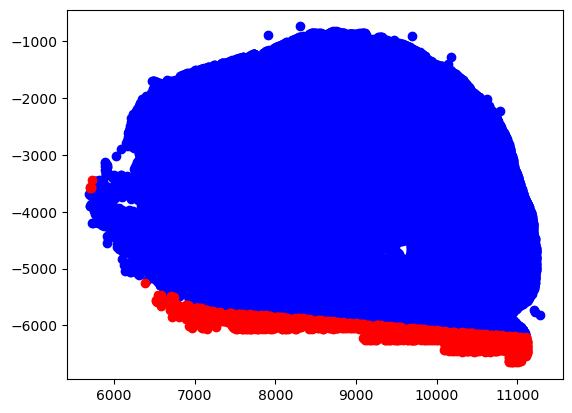

In [61]:
# show where the NAs are
slice_id = 'co1_slice30'
test_slice = cmd[cmd['slice_id'] == slice_id]
test_slice_not_NA = test_slice[~test_slice.ccfx.isna()]
test_slice_NA = test_slice[test_slice.ccfx.isna()]

plt.scatter(test_slice_not_NA.center_x, test_slice_not_NA.center_y, color = 'b')
plt.scatter(test_slice_NA.center_x, test_slice_NA.center_y, color = 'r')

In [62]:
# be careful of this drop NA step 
# it is important for transformix to not have any NA values

cmd = cmd[~cmd.annotation.isna()]
len(cmd)

1794161

In [63]:
if np.any(cmd.columns.isin(['ccfx_2', 'ccfy_2', 'ccfz_2', 'annotation_2'])):
    cmd.drop(columns=['ccfx_2', 'ccfy_2', 'ccfz_2', 'annotation_2'], inplace = True)

z = cmd.ccfx.values/ccf_pixel_size
y = cmd.ccfy.values/ccf_pixel_size
x = cmd.ccfz.values/ccf_pixel_size
cells_pos = np.array([x, y, z]).T # - 0.5 # correction to ITK Voroni pixel?

# write the files to the disk
write_pts_file(cells_pos)

In [64]:
# warp the points
transformixImageFilter = sitk.TransformixImageFilter()
transformixImageFilter.SetTransformParameterMap(trans)
transformixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving_1))
transformixImageFilter.SetFixedPointSetFileName('points.pts')
transformixImageFilter.Execute()

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x0000019B41592510> >

In [65]:
# read back the transformed points
output_points = read_outputpoints_file()
cells_pos_moving = output_points[:,3]

In [66]:
xloc = cells_pos_moving[:,0]
yloc = cells_pos_moving[:,1]
zloc = cells_pos_moving[:,2]

cells_pos_select = ((zloc.astype(int) < annot.shape[0] - 1) & (zloc.astype(int) >= 0) &
                    (yloc.astype(int) < annot.shape[1] - 1) & (yloc.astype(int) >= 0) &
                    (xloc.astype(int) < annot.shape[2] - 1) & (xloc.astype(int) >= 0))

xloc = xloc[cells_pos_select]
yloc = yloc[cells_pos_select]
zloc = zloc[cells_pos_select]

cells_annotations = annot[zloc.astype(int), yloc.astype(int), xloc.astype(int)]

idx = cmd.index[cells_pos_select]
cmd.loc[idx, 'ccfx_2'] = zloc * ccf_pixel_size
cmd.loc[idx, 'ccfy_2'] = yloc * ccf_pixel_size
cmd.loc[idx, 'ccfz_2'] = xloc * ccf_pixel_size
cmd.loc[:, 'annotation_2'] = np.nan # be careful here assigning NAN as default value.. is this smart?
cmd.loc[idx, 'annotation_2'] = cells_annotations

In [67]:
# save the 3d registration result
cmd.to_csv('wb3_co1_all_ccf3d.csv', index = True)

### display registration results

In [68]:
annot_10, header = nrrd.read(ara_annot_10_file, index_order='F')
print(annot.shape)

(528, 320, 236)


In [69]:
# this is for a curved boundary from 3D registration

def get_curved_border(cmd_subset, border_image3d, pixsize = 10, expand = 20, reflect = True):
    cmd_subset = cmd_subset.dropna()
    imdim = border_image3d[0].shape
    z_contour = np.zeros(imdim, dtype = np.uint16)
    y = (cmd_subset.ccfy_2/pixsize).astype(int)
    x = (cmd_subset.ccfz_2/pixsize).astype(int)
    z_contour[y,x] = (cmd_subset.ccfx_2/pixsize).astype(int)
    z_contour = skimage.segmentation.expand_labels(z_contour, expand)
    yy, xx = np.mgrid[0:imdim[0], 0:imdim[1]]
    output = border_image3d[z_contour, yy, xx]
    if reflect:
        center = int(imdim[1]/2)
        output[:,center:] = output[:,center:0:-1]
    return output

# this is for a 2D registration

def get_2D_border(cmd_subset, border_image3d, pixsize = 10, expand = 20, reflect = True):
    cmd_subset = cmd_subset.dropna()
    imdim = border_image3d[0].shape
    z_contour = np.zeros(imdim, dtype = np.uint16)
    y = (cmd_subset.ccfy/pixsize).astype(int)
    x = (cmd_subset.ccfz/pixsize).astype(int)
    z_contour[y,x] = (cmd_subset.ccfx/pixsize).astype(int)
    z_contour = skimage.segmentation.expand_labels(z_contour, expand)
    yy, xx = np.mgrid[0:imdim[0], 0:imdim[1]]
    output = border_image3d[z_contour, yy, xx]
    if reflect:
        center = int(imdim[1]/2)
        output[:,center:] = output[:,center:0:-1]
    return output

# add boundaries between regions
# added gaussian smoothing (set to zero for no smoothing)
def make_vector_outlines(im, smoothing = 1.5, threshhold = 0.5):
    output = []
    vals = np.unique(im)[1::] # this one drops the zero value
    for v in vals:
        mask = (im == v)
        if smoothing == 0:
            mask_contour = skimage.measure.find_contours(mask, 0.99)
        else:
            mask = skimage.filters.gaussian(mask, sigma = smoothing)
            mask_contour = skimage.measure.find_contours(mask, threshhold)
        output.append(mask_contour)
    output = [item for sublist in output for item in sublist]
    return output

In [70]:
%matplotlib inline

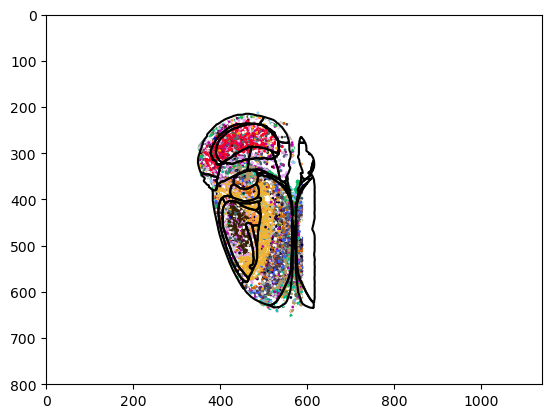

In [71]:
cmd_temp = cmd[cmd.slice_id == "co1_slice12"]
curved = get_curved_border(cmd_temp, annot_10, pixsize = 10, expand = 30, reflect = False)
outlines = make_vector_outlines(curved, smoothing = 1)

fig = plt.figure()
plt.scatter(cmd_temp.ccfz_2/10, cmd_temp.ccfy_2/10, s = 1, c = cmd_temp.lvl2_colors)    
for outline in outlines:
    plt.plot(*np.flip(outline.T), 'k')
ax = plt.gca()
ax.set_ylim(0,800)
ax.set_xlim(0,1140)
ax.invert_yaxis()

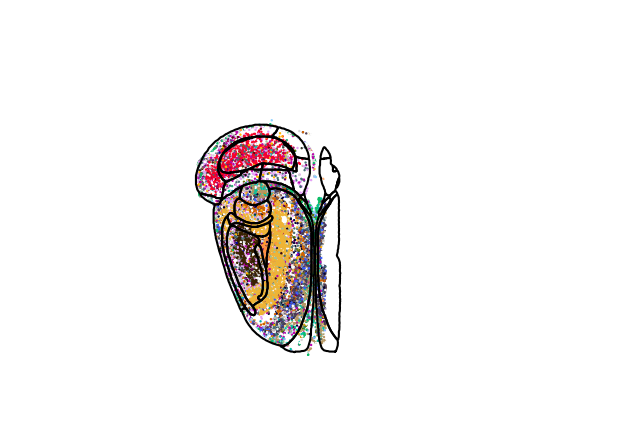

In [72]:
borders_2d = get_2D_border(cmd_temp, annot_10, pixsize = 10, expand = 30, reflect = False)
outlines = make_vector_outlines(borders_2d, smoothing = 1)

fig = plt.figure()
plt.scatter(cmd_temp.ccfz/10, cmd_temp.ccfy/10, s = .5, c = cmd_temp.lvl2_colors)
for outline in outlines:
    plt.plot(*np.flip(outline.T), 'k')
ax = plt.gca()
ax.set_ylim(0,800)
ax.set_xlim(0,1140)
ax.invert_yaxis()
ax.set_aspect('equal')
#plt.xticks([])
#plt.yticks([])
plt.axis('off')
plt.tight_layout()
#fig.savefig('test.png', transparent = True, dpi = 300)

In [73]:
# assemble and order all the slice ids
slice_ids = cmd.slice_id.unique()
slide_ids_order = np.argsort([int(sid[9:]) for sid in slice_ids])
slice_ids = slice_ids[slide_ids_order]
slice_ids

array(['co1_slice4', 'co1_slice5', 'co1_slice6', 'co1_slice7',
       'co1_slice8', 'co1_slice9', 'co1_slice10', 'co1_slice11',
       'co1_slice12', 'co1_slice13', 'co1_slice14', 'co1_slice15',
       'co1_slice16', 'co1_slice17', 'co1_slice18', 'co1_slice19',
       'co1_slice20', 'co1_slice21', 'co1_slice22', 'co1_slice23',
       'co1_slice25', 'co1_slice26', 'co1_slice27', 'co1_slice28',
       'co1_slice30', 'co1_slice31', 'co1_slice32', 'co1_slice33',
       'co1_slice34', 'co1_slice35', 'co1_slice36', 'co1_slice37',
       'co1_slice39', 'co1_slice40', 'co1_slice41', 'co1_slice42',
       'co1_slice44', 'co1_slice45', 'co1_slice46', 'co1_slice47',
       'co1_slice48', 'co1_slice49', 'co1_slice50', 'co1_slice51',
       'co1_slice52', 'co1_slice53', 'co1_slice54', 'co1_slice55',
       'co1_slice56', 'co1_slice57', 'co1_slice58', 'co1_slice59',
       'co1_slice60', 'co1_slice61'], dtype=object)

In [74]:
transparent = False

plt.ioff()

for sid in slice_ids:
    print('working on slice id {}'.format(sid), end = '\r')
    cmd_temp = cmd[cmd.slice_id == sid]
    curve = get_curved_border(cmd_temp, annot_10, pixsize = 10, expand = 30, reflect = False)
    outlines = make_vector_outlines(curve, smoothing = 1)
    
    fig = plt.figure(figsize = [7,10])
    plt.scatter(cmd_temp.ccfz_2/10, cmd_temp.ccfy_2/10, s = .5, c = cmd_temp.lvl2_colors)
    for outline in outlines:
        plt.plot(*np.flip(outline.T), 'k')
    ax = plt.gca()
    ax.set_ylim(0,800)
    ax.set_xlim(0,1140)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.axis('off')
    plt.tight_layout()
    fig.savefig('{} 3d reg.png'.format(sid), transparent = transparent, dpi = 300)
    plt.close()
plt.ion()

In [75]:
transparent = False

plt.ioff()

for sid in slice_ids:
    print('working on slice id {}'.format(sid), end = '\r')
    cmd_temp = cmd[cmd.slice_id == sid]
    curve = get_2D_border(cmd_temp, annot_10, pixsize = 10, expand = 30, reflect = False)
    outlines = make_vector_outlines(curve, smoothing = 1)
    
    fig = plt.figure(figsize = [7,10])
    plt.scatter(cmd_temp.ccfz/10, cmd_temp.ccfy/10, s = .5, c = cmd_temp.lvl2_colors)
    for outline in outlines:
        plt.plot(*np.flip(outline.T), 'k')
    ax = plt.gca()
    ax.set_ylim(0,800)
    ax.set_xlim(0,1140)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.axis('off')
    plt.tight_layout()
    fig.savefig('{} 2d reg.png'.format(sid), transparent = transparent, dpi = 300)
    plt.close()

plt.ion()

### Transform annotated image back to MERFISH space

In [76]:
len(cmd)

1794161

In [77]:
# add boundaries between regions
# added gaussian smoothing (set to zero for no smoothing)
def make_vector_outlines(im, smoothing = 1.5, threshhold = 0.5, scale = 1, border = 1):
    output = []
    
    # clear the edge 
    im[0:border] = 0
    im[-border:] = 0
    im[:,0:border] = 0
    im[:,-border:] = 0
    
    vals = np.unique(im)[1::] # this one drops the zero value
    for v in vals:
        mask = (im == v)
        if smoothing == 0:
            mask_contour = skimage.measure.find_contours(mask, 0.99)
        else:
            mask = skimage.filters.gaussian(mask, sigma = smoothing)
            mask_contour = skimage.measure.find_contours(mask, threshhold)
        output.append(mask_contour)
    output = [item * scale for sublist in output for item in sublist]
    return output

# add boundaries between regions
# added gaussian smoothing (set to zero for no smoothing)
def make_vector_outlines_dict(im, smoothing = 1.5, threshhold = 0.5, scale = 1, border = 1):
    output = {}

    # clear the edge 
    im[0:border] = 0
    im[-border:] = 0
    im[:,0:border] = 0
    im[:,-border:] = 0
    
    vals = np.unique(im)[1::] # this one drops the zero value
    for v in vals:
        mask = (im == v)
        if smoothing == 0:
            mask_contour = skimage.measure.find_contours(mask, 0.99)
        else:
            mask = skimage.filters.gaussian(mask, sigma = smoothing)
            mask_contour = skimage.measure.find_contours(mask, threshhold)
            
        if len(mask_contour) > 0:
            output[v] = [contour * scale for contour in mask_contour]
    return output

In [78]:
def convert_outlines_to_merlin(df, index, cmd, outlines_dict, ccf_pixel_size = 25, bbox = None, pad_width = 20):
    file = df.iloc[index].Filename
    rot = df.iloc[index].rot_init
    reflect = df.iloc[index].reflect
    scale_x, scale_y = [df.iloc[index].scale_x, df.iloc[index].scale_y]
    dataname, slicenum, y1, y2, x1, x2 = parse_filename(file)
    # need to know some stuff about the raw image
    imraw = skimage.io.imread(file)
    imdim = np.array(imraw.shape)
    imcenter = find_center(imraw)
    umperpixY = (y2-y1)/imdim[0]
    umperpixX = (x2-x1)/imdim[1]
    
    # here is the cell metadata subset
    cmd_temp = cmd[cmd.sample_id == df.iloc[index].cell_metadata]
    
    cells =  cmd_temp[(y1 < cmd_temp['center_y']) &
              (cmd_temp['center_y'] < y2) & 
              (x1 < cmd_temp['center_x']) & 
              (cmd_temp['center_x'] < x2)].copy() # make a copy so it does not give the slice warning...
    
    tform1 = mat_trans(-x1,-y1) # move the corner of the image to the origin
    tform2 = mat_scale(1/umperpixX, 1/umperpixY) # scale the image into pixels
    tform3 = mat_trans(imcenter[1],imcenter[0]) @ mat_rot(-rot) @ mat_trans(-imcenter[1],-imcenter[0]) # do initial rotation (translated to the center, rotate, translate back)
    shiftr, shiftc, out_rows, out_cols = find_new_corner(imdim[0], imdim[1], -rot) # find the new size of the image since it was rotated
    tform4 = mat_trans(-shiftc,-shiftr) # shift to the new corner
    tform5 = mat_reflect(reflect = reflect, dx = out_cols) # reflect if there is a reflection
    tform6 = mat_scale(scale_x,scale_y) # do final scaling in x and y which was added for better registration
    tform7 = mat_trans(-bbox[1],-bbox[0]) # crop in on the cells
    tform8 = mat_trans(pad_width,pad_width) # add padding
    tform =  tform8 @ tform7 @ tform6 @ tform5 @ tform4 @ tform3 @ tform2 @ tform1 # final transform of everything!
    
    # we will invert the transform here since we want to move back to MERLIN space
    tform = np.linalg.inv(tform)
    
    cells_pos_merlin = np.array([cells['center_x'], cells['center_y']]).T

    outlines_transformed = {}
    for key, outlines in outlines_dict.items():
        new_outlines = []
        for outline in outlines:
            new_outlines.append(transform_positions(tform, np.flip(outline, axis = 1)))
            
        outlines_transformed[key] = new_outlines

    return outlines_transformed, cells_pos_merlin, cells

In [79]:
def convert_outlines_to_fixed(df, index, cmd, outlines_dict, ccf_pixel_size = 25, bbox = None, pad_width = 20):
    file = df.iloc[index].Filename
    rot = df.iloc[index].rot_init
    reflect = df.iloc[index].reflect
    scale_x, scale_y = [df.iloc[index].scale_x, df.iloc[index].scale_y]
    dataname, slicenum, y1, y2, x1, x2 = parse_filename(file)
    # need to know some stuff about the raw image
    imraw = skimage.io.imread(file)
    imdim = np.array(imraw.shape)
    imcenter = find_center(imraw)
    umperpixY = (y2-y1)/imdim[0]
    umperpixX = (x2-x1)/imdim[1]
    
    # here is the cell metadata subset
    cmd_temp = cmd[cmd.sample_id == df.iloc[index].cell_metadata]
    
    cells =  cmd_temp[(y1 < cmd_temp['center_y']) &
                  (cmd_temp['center_y'] < y2) & 
                  (x1 < cmd_temp['center_x']) & 
                  (cmd_temp['center_x'] < x2)].copy() # make a copy so it does not give the slice warning...
    
    tform1 = mat_trans(-x1,-y1) # move the corner of the image to the origin
    tform2 = mat_scale(1/umperpixX, 1/umperpixY) # scale the image into pixels
    tform3 = mat_trans(imcenter[1],imcenter[0]) @ mat_rot(-rot) @ mat_trans(-imcenter[1],-imcenter[0]) # do initial rotation (translated to the center, rotate, translate back)
    shiftr, shiftc, out_rows, out_cols = find_new_corner(imdim[0], imdim[1], -rot) # find the new size of the image since it was rotated
    tform4 = mat_trans(-shiftc,-shiftr) # shift to the new corner
    tform5 = mat_reflect(reflect = reflect, dx = out_cols) # reflect if there is a reflection
    
    # convert to microns?
    tform_um = mat_scale(umperpixX, umperpixY) 
    
    tform =  tform_um @ tform5 @ tform4 @ tform3 @ tform2 @ tform1
    
    cells_pos = np.array([cells['center_x'], cells['center_y']]).T
    cells_pos_image_space = transform_positions(tform, cells_pos) # transform the cell positions from the initial transforms
    cells['fixed_x'] = cells_pos_image_space[:,0]
    cells['fixed_y'] = cells_pos_image_space[:,1]
    
    # transforming contours
    
    tform6 = mat_scale(scale_x,scale_y) # do final scaling in x and y which was added for better registration
    tform7 = mat_trans(-bbox[1],-bbox[0]) # crop in on the cells
    tform8 = mat_trans(pad_width,pad_width) # add padding
    tform_rev =  tform8 @ tform7 @ tform6
    
    tform_rev = tform8 @ tform7 @ tform6
    tform_rev = np.linalg.inv(tform_rev)

    # convert to microns?
    tform_rev = tform_um @ tform_rev
    
    outlines_transformed = {}
    for key, outlines in outlines_dict.items():
        new_outlines = []
        for outline in outlines:
            new_outlines.append(transform_positions(tform_rev, np.flip(outline, axis = 1)))
            
        outlines_transformed[key] = new_outlines

    return outlines_transformed, cells_pos_image_space, cells

In [80]:
cmd_temp = cmd[cmd.sample_id == df.iloc[20].cell_metadata]
cmd_temp.columns

Index(['fov', 'volume', 'center_x', 'center_y', 'sample_id', 'slice_id',
       'fov_x', 'fov_y', 'integration_partition_transfer',
       'integration_partition_confidence', 'subclass_label_transfer',
       'subclass_label_confidence', 'cl_transfer', 'cl_confidence',
       'cluster_cosine_similarity', 'adjusted_subclass_label_confidence',
       'adjusted_cl_confidence', 'spatial_modules_level_1', 'sm1_color',
       'local_color', 'spatial_modules_level_1_name', 'sm1n_color',
       'lvl2_colors', 'ccfx', 'ccfy', 'ccfz', 'annotation', 'ccfx_2', 'ccfy_2',
       'ccfz_2', 'annotation_2'],
      dtype='object')

In [81]:
# load in the high resolution annotated image
# note time stamp in name of when it was generated
annot_3d = skimage.io.imread(r'moving_3D_spline_10_1690742496.tif')
annot_3d = np.rint(annot_3d).astype(np.uint32)

annot_3d = annot_3d[:,:,:-int(10 * 2.5)] # remove the pad

annot_3d.shape

(1320, 800, 590)

In [82]:
# make sure this is the same size
np.array(annot.shape) * 2.5

array([1320.,  800.,  590.])

### make an annotated image in MERFISH space

In [83]:
%matplotlib qt

In [84]:
# make this exactly like 2D registration at the beginning of the notebook

slice_to_register = 30

print('start register slice {}'.format(slice_to_register))

num = slice_to_register - 1

df = import_df(slice_info_filename)
ccf_pixel_size = 25

filename = df.iloc[num].Filename
allen_slice_num = df.iloc[num].allen_slice_num
allen_slice_num_10 = int(allen_slice_num * 2.5)

rescale_percent = 0.99

moving_annot = annot[allen_slice_num]
moving_borders = borders[allen_slice_num]
nissl_im = nissl[allen_slice_num]

fixed = modify_dapi(df, num, cmd,
    cell_types = df.iloc[num].cell_types,
    space_modules = df.iloc[num].space_modules,
    factor = df.iloc[num].dapi_enhance_factor)

moving  = modify_nissl(nissl_im, moving_annot,
    annot_dict = df.iloc[num].annots_to_amplify,
    factor = df.iloc[num].nissl_enhance_factor)

output_10 = np.zeros((np.array(fixed.shape) * 2.5).astype(int))

# make some params
p, p2 = params_from_df(df, num)
# crop and pad images

pad_width = df.iloc[num].pad_width
print('pad width set to {}'.format(pad_width))
# probably should jsut fix the aspect ratio issue which was a legacy from similarty transform

# crop images (may not be necessary since we did it already) and add a pad
fix_bbox, fixed, _ = crop_and_pad_image(fixed, pad_width = pad_width, area_thresh = 300)
_, _, moving_borders = crop_and_pad_image(moving, moving_borders, pad_width = pad_width, area_thresh = 300) # be careful here don't overwrite the original moving...
mov_bbox, moving, moving_annot = crop_and_pad_image(moving, moving_annot, pad_width = pad_width, area_thresh = 300) 

# check if there are corresponding points
csv_file = os.path.splitext(filename)[0] + '.csv'
if os.path.exists(csv_file):
    print('corresponding points found')
    cor_points = pd.read_csv(csv_file)
    fix_points = cor_points[['fix_x', 'fix_y']].values
    mov_points = cor_points[['mov_x', 'mov_y']].values

    write_pts_file(fix_points, name = 'fix.pts')
    write_pts_file(mov_points, name = 'mov.pts')

# making the high res annotated image
# here is the slice from the 3d registration
annot_3d_slice = annot_3d[allen_slice_num_10]
mov_bbox_10 = (np.array(mov_bbox) * 2.5).astype(int)
annot_3d_slice = np.pad(annot_3d_slice[mov_bbox_10[0]:mov_bbox_10[2],mov_bbox_10[1]:mov_bbox_10[3]], int(2.5*pad_width))

print('slice num {}'.format(df.iloc[num].Slice))
print('allen slice {}'.format(allen_slice_num))
print('registering in progress')

# register a slice to allen
trans, moving_spline = register_images(fixed, moving, p, p2)

# transform other images
moving_rigid = transform_image(moving, trans[0])
moving_annot_rigid = annot_revert[transform_image(annot_convert[moving_annot], trans[0], interpolation = False).astype(np.uint32)]
moving_annot_spline = annot_revert[transform_image(annot_convert[moving_annot], trans, interpolation = False).astype(np.uint32)]
moving_borders_spline = transform_image(moving_borders, trans, interpolation = True)

trans_10 = copy.copy(trans)
fixed_10_shape = (np.array(fixed.shape) * 2.5).astype(int)
for tran in trans_10:
    tran['Size'] = L2P(np.flip(fixed_10_shape))
    tran['Spacing'] = L2P([0.4,0.4])

annot_3d_slice_spline = annot_revert[transform_image(annot_convert[annot_3d_slice], trans_10, interpolation = False, spacing = (0.4,0.4)).astype(np.uint32)]
plt.figure('test')
plt.imshow(annot_3d_slice_spline, vmin = 0, vmax = 1000)

# this is the original size image?
pad = int(2.5 * pad_width)
annot_3d_slice_spline = annot_3d_slice_spline[pad:-pad,pad:-pad] # remove pad

fix_bbox_10 = (np.array(fix_bbox) * 2.5).astype(int)
w, h = annot_3d_slice_spline.shape
r = int(fix_bbox_10[0])
c = int(fix_bbox_10[1])
output_10[r:r+w,c:c+h] = annot_3d_slice_spline
annot_3d_slice_spline = output_10

# get some cell positions
if True:
    cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size,
                                              bbox = fix_bbox,
                                              pad_width = pad_width)
    cells_pos_fixed = np.array([cells['fixed_x'], cells['fixed_y']]).T 
    # take the slice id with the most cells (sometimes they can be mixed...)
    slice_id = cells.slice_id.value_counts().index[0]
    print(slice_id)

percent_high = 0.95

# cells converted 3d registration
fig2, axs = plt.subplots(1,2, figsize = (15,10))

#2d registration with borders
axs[0].set_title('borders')
axs[0].set_facecolor((1,1,1))
axs[0].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.3, c = cells['lvl2_colors'])
axs[0].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))
#3d registration with vector outlines
axs[1].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.3, c = cells['lvl2_colors'])


# Make the vector outlines
outlines_dict = make_vector_outlines_dict(annot_3d_slice_spline, smoothing = 1, threshhold = 0.5, scale = 0.4)

# cells and outlines in fixed space
fig4, ax = plt.subplots(1,1)
outlines_fixed_dict, cell_pos_fixed, cells = convert_outlines_to_fixed(df, num, cmd, outlines_dict,
                                                                 ccf_pixel_size = ccf_pixel_size,
                                                                 bbox = [0,0],
                                                                 pad_width = 0)
for key, outlines in outlines_fixed_dict.items():
    for outline in outlines:
        ax.plot(*outline.T, 'k')   
ax.scatter(cell_pos_fixed[:,0],cell_pos_fixed[:,1], s = 0.3, c = cells['lvl2_colors'])
ax.invert_yaxis()

# cells and tiff in fixed space
fig5, ax = plt.subplots(1,1)

sizey, sizex = annot_3d_slice_spline.shape
sizex2 = int(np.rint(sizex / df.iloc[num].scale_x))
sizey2 = int(np.rint(sizey / df.iloc[num].scale_y))

#resize back the fixed size
#the image must be float, the order must be zero and then convert back to uint32 when done
#otherwise annotations get messed up
annot_3d_slice_spline_fixed = skimage.transform.resize(annot_3d_slice_spline.astype(float), (sizey2, sizex2), order = 0, preserve_range = True)
annot_3d_slice_spline_fixed = np.rint(annot_3d_slice_spline_fixed).astype(np.uint32)
ax.scatter(cell_pos_fixed[:,0]/10,cell_pos_fixed[:,1]/10, s = 0.3, c = cells['lvl2_colors'], edgecolors = None)
ax.imshow(annot_3d_slice_spline_fixed, cmap = 'gray', vmin = 0, vmax = 1000)

# save these coordinates to the cmd dataframe
cmd.loc[cells.index, 'fixed_x'] = cell_pos_fixed[:,0]
cmd.loc[cells.index, 'fixed_y'] = cell_pos_fixed[:,1]

fig4.savefig('{}_fixed_space.png'.format(slice_id))
fig5.savefig('{}_fixed_cells.png'.format(slice_id))

skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)
    
print('done')

start register slice 30
corresponding points file found: 220308_wb3_co1_7_3z19R_merfish5_slice2_y_-005778_000044_x_0004371_009994_25um_pix.csv
pad width set to 20
corresponding points found
slice num 30
allen slice 234
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice32
done


In [85]:
matplotlib.use('Agg')

istart = 4 #4
istop = 58 #58
rescale_percent = 0.99

plotQ = True

# Do a loop of a bunch of slices
slices_to_register = np.arange(istart,istop).astype(int)

for slice_to_register in slices_to_register:
    num = slice_to_register - 1
    
    print('working on slice {}/{}'.format(slice_to_register,slices_to_register[-1]))

    df = import_df(slice_info_filename)
    ccf_pixel_size = 25

    filename = df.iloc[num].Filename
    allen_slice_num = df.iloc[num].allen_slice_num
    allen_slice_num_10 = int(allen_slice_num * 2.5)

    rescale_percent = 0.99

    moving_annot = annot[allen_slice_num]
    moving_borders = borders[allen_slice_num]
    nissl_im = nissl[allen_slice_num]

    fixed = modify_dapi(df, num, cmd,
        cell_types = df.iloc[num].cell_types,
        space_modules = df.iloc[num].space_modules,
        factor = df.iloc[num].dapi_enhance_factor)

    moving  = modify_nissl(nissl_im, moving_annot,
        annot_dict = df.iloc[num].annots_to_amplify,
        factor = df.iloc[num].nissl_enhance_factor)

    output_10 = np.zeros((np.array(fixed.shape) * 2.5).astype(int))

    # make some params
    p, p2 = params_from_df(df, num)
    # crop and pad images

    pad_width = df.iloc[num].pad_width
    print('pad width set to {}'.format(pad_width))
    # probably should jsut fix the aspect ratio issue which was a legacy from similarty transform
    # crop images (may not be necessary since we did it already) and add a pad
    fix_bbox, fixed, _ = crop_and_pad_image(fixed, pad_width = pad_width, area_thresh = 300)
    _, _, moving_borders = crop_and_pad_image(moving, moving_borders, pad_width = pad_width, area_thresh = 300) # be careful here don't overwrite the original moving...
    mov_bbox, moving, moving_annot = crop_and_pad_image(moving, moving_annot, pad_width = pad_width, area_thresh = 300) 

    # check if there are corresponding points
    csv_file = os.path.splitext(filename)[0] + '.csv'
    if os.path.exists(csv_file):
        print('corresponding points found')
        cor_points = pd.read_csv(csv_file)
        fix_points = cor_points[['fix_x', 'fix_y']].values
        mov_points = cor_points[['mov_x', 'mov_y']].values

        write_pts_file(fix_points, name = 'fix.pts')
        write_pts_file(mov_points, name = 'mov.pts')

    # making the high res annotated image
    # here is the slice from the 3d registration
    annot_3d_slice = annot_3d[allen_slice_num_10]
    mov_bbox_10 = (np.array(mov_bbox) * 2.5).astype(int)
    annot_3d_slice = np.pad(annot_3d_slice[mov_bbox_10[0]:mov_bbox_10[2],mov_bbox_10[1]:mov_bbox_10[3]], int(2.5*pad_width))

    print('slice num {}'.format(df.iloc[num].Slice))
    print('allen slice {}'.format(allen_slice_num))
    print('registering in progress')

    # register a slice to allen
    trans, moving_spline = register_images(fixed, moving, p, p2)

    # transform other images
    moving_rigid = transform_image(moving, trans[0])
    moving_annot_rigid = annot_revert[transform_image(annot_convert[moving_annot], trans[0], interpolation = False).astype(np.uint32)]
    moving_annot_spline = annot_revert[transform_image(annot_convert[moving_annot], trans, interpolation = False).astype(np.uint32)]
    moving_borders_spline = transform_image(moving_borders, trans, interpolation = True)

    trans_10 = copy.copy(trans)
    fixed_10_shape = (np.array(fixed.shape) * 2.5).astype(int)
    for tran in trans_10:
        tran['Size'] = L2P(np.flip(fixed_10_shape))
        tran['Spacing'] = L2P([0.4,0.4])

    annot_3d_slice_spline = annot_revert[transform_image(annot_convert[annot_3d_slice], trans_10, interpolation = False, spacing = (0.4,0.4)).astype(np.uint32)]
    plt.figure('test')
    plt.imshow(annot_3d_slice_spline, vmin = 0, vmax = 1000)

    # this is the original size image?
    pad = int(2.5 * pad_width)
    annot_3d_slice_spline = annot_3d_slice_spline[pad:-pad,pad:-pad] # remove pad

    fix_bbox_10 = (np.array(fix_bbox) * 2.5).astype(int)
    w, h = annot_3d_slice_spline.shape
    r = int(fix_bbox_10[0])
    c = int(fix_bbox_10[1])
    output_10[r:r+w,c:c+h] = annot_3d_slice_spline
    annot_3d_slice_spline = output_10

    # get some cell positions
    if True:
        cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size,
                                                  bbox = fix_bbox,
                                                  pad_width = pad_width)
        cells_pos_fixed = np.array([cells['fixed_x'], cells['fixed_y']]).T
        # take the slice id with the most cells (sometimes they can be mixed...)
        slice_id = cells.slice_id.value_counts().index[0]
        print(slice_id)

    percent_high = 0.95

    # cells converted 3d registration
    fig2, axs = plt.subplots(1,2, figsize = (15,10))

    #2d registration with borders
    axs[0].set_title('borders')
    axs[0].set_facecolor((1,1,1))
    axs[0].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.3, c = cells['lvl2_colors'])
    axs[0].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))
    #3d registration with vector outlines
    axs[1].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.3, c = cells['lvl2_colors'])


    # Make the vector outlines
    outlines_dict = make_vector_outlines_dict(annot_3d_slice_spline, smoothing = 1, threshhold = 0.5, scale = 0.4)

    # cells and outlines in fixed space
    fig4, ax = plt.subplots(1,1)
    outlines_fixed_dict, cell_pos_fixed, cells = convert_outlines_to_fixed(df, num, cmd, outlines_dict,
                                                                     ccf_pixel_size = ccf_pixel_size,
                                                                     bbox = [0,0],
                                                                     pad_width = 0)
    for key, outlines in outlines_fixed_dict.items():
        for outline in outlines:
            ax.plot(*outline.T, 'k')   
    ax.scatter(cell_pos_fixed[:,0],cell_pos_fixed[:,1], s = 0.3, c = cells['lvl2_colors'])
    ax.invert_yaxis()

    # cells and tiff in fixed space
    fig5, ax = plt.subplots(1,1)

    sizey, sizex = annot_3d_slice_spline.shape
    sizex2 = int(np.rint(sizex / df.iloc[num].scale_x))
    sizey2 = int(np.rint(sizey / df.iloc[num].scale_y))

    #resize back the fixed size
    #the image must be float, the order must be zero and then convert back to uint32 when done
    #otherwise annotations get messed up
    annot_3d_slice_spline_fixed = skimage.transform.resize(annot_3d_slice_spline.astype(float), (sizey2, sizex2), order = 0, preserve_range = True)
    annot_3d_slice_spline_fixed = np.rint(annot_3d_slice_spline_fixed).astype(np.uint32)
    ax.scatter(cell_pos_fixed[:,0]/10,cell_pos_fixed[:,1]/10, s = 0.3, c = cells['lvl2_colors'], edgecolors = None)
    ax.imshow(annot_3d_slice_spline_fixed, cmap = 'gray', vmin = 0, vmax = 1000)

    # save these coordinates to the cmd dataframe
    cmd.loc[cells.index, 'fixed_x'] = cell_pos_fixed[:,0]
    cmd.loc[cells.index, 'fixed_y'] = cell_pos_fixed[:,1]

    fig4.savefig('{}_fixed_space.png'.format(slice_id))
    fig5.savefig('{}_fixed_cells.png'.format(slice_id))

    skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)

    plt.close('all')

working on slice 4/57
corresponding points file found: 220408_wb3_co_4B_merfish4_adaptor_slice0_y_0002079_004302_x_-003275_-00452_25um_pix.csv
pad width set to 20
corresponding points found
slice num 4
allen slice 20
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice4


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice4_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 5/57
pad width set to 20
slice num 5
allen slice 28
registering in progress
SITK spacing set to (0.4, 0.4)
co1_slice5


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice5_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 6/57
corresponding points file found: 220422_wb3_co1_1B_6z18R_merfish5_slice1_y_-009864_-06641_x_0003565_006388_25um_pix.csv
pad width set to 20
corresponding points found
slice num 6
allen slice 36
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice6


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice6_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 7/57
corresponding points file found: 220412_wb3_co_2B_merfish4_adaptor_slice1_y_0001765_005188_x_-003769_-01146_25um_pix.csv
pad width set to 20
corresponding points found
slice num 7
allen slice 45
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice7


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice7_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 8/57
corresponding points file found: 220308_wb3_co_3_merfish4_slice1_y_-004210_-00987_x_0001652_004476_25um_pix.csv
pad width set to 20
corresponding points found
slice num 8
allen slice 53
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice8


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice8_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 9/57
corresponding points file found: 220408_wb3_co_4B_merfish4_adaptor_slice1_y_0001621_005845_x_0003332_006755_25um_pix.csv
pad width set to 20
corresponding points found
slice num 9
allen slice 62
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice9


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice9_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 10/57
corresponding points file found: 220411_wb3_co1_5B_6z19R_merfish5_slice1_y_0003495_007118_x_-007488_-05065_25um_pix.csv
pad width set to 20
corresponding points found
slice num 10
allen slice 70
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice10


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice10_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 11/57
corresponding points file found: 220422_wb3_co1_1B_6z18R_merfish5_slice2_y_-008173_-04150_x_-001697_000925_25um_pix.csv
pad width set to 20
corresponding points found
slice num 11
allen slice 79
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice11


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice11_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 12/57
corresponding points file found: 220412_wb3_co_2B_merfish4_adaptor_slice2_y_0002227_005851_x_-000201_002421_25um_pix.csv
pad width set to 20
corresponding points found
slice num 12
allen slice 82
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice12


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice12_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 13/57
corresponding points file found: 220308_wb3_co_3_merfish4_slice2_y_-003169_000654_x_-003897_-01073_25um_pix.csv
pad width set to 20
corresponding points found
slice num 13
allen slice 88
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice13
working on slice 14/57
corresponding points file found: 220408_wb3_co_4B_merfish4_adaptor_slice2_y_-003399_-00176_x_-000391_003831_25um_pix.csv
pad width set to 20
corresponding points found
slice num 14
allen slice 96
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice14
working on slice 15/57
pad width set to 20
slice num 15
allen slice 103
registering in progress
SITK spacing set to (0.4, 0.4)
co1_slice15
working on slice 16/57
corresponding points file found: 220422_wb3_co1_1B_6z18R_merfish5_slice3_y_-002151_001271_x_-001295_002927_25um_pix.csv
pad width set to 20
corresponding points found
slice num 16
allen slice 110
registering in progress
loa

C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice16_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 17/57
corresponding points file found: 220412_wb3_co_2B_merfish4_adaptor_slice3_y_-005544_-01520_x_0000955_004578_25um_pix.csv
pad width set to 20
corresponding points found
slice num 17
allen slice 117
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice17


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice17_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 18/57
pad width set to 20
slice num 18
allen slice 123
registering in progress
SITK spacing set to (0.4, 0.4)
co1_slice18


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice18_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 19/57
pad width set to 20
slice num 19
allen slice 131
registering in progress
SITK spacing set to (0.4, 0.4)
co1_slice19


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice19_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 20/57
corresponding points file found: 220411_wb3_co1_5B_6z19R_merfish5_slice3_y_-003091_001931_x_-001508_002915_25um_pix.csv
pad width set to 20
corresponding points found
slice num 20
allen slice 138
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice20


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice20_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 21/57
corresponding points file found: 220422_wb3_co1_6B_6z18R_merfish6_slice0_y_-002785_001638_x_-002506_002116_25um_pix.csv
pad width set to 20
corresponding points found
slice num 21
allen slice 145
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice21


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice21_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 22/57
corresponding points file found: 220308_wb3_co1_7_3z19R_merfish5_slice0_y_-009561_-04737_x_-002976_002447_25um_pix.csv
pad width set to 20
corresponding points found
slice num 22
allen slice 155
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice22


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice22_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 23/57
corresponding points file found: 220408_wb3_co1_8B_6z19R_merfish5_slice0_y_-003749_001274_x_-002699_002524_25um_pix.csv
pad width set to 20
corresponding points found
slice num 23
allen slice 163
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice23


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice23_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 24/57
corresponding points file found: 220418_wb3_co1_10B_6z18R_merfish5_slice0_y_0000161_005584_x_0005298_010921_25um_pix.csv
pad width set to 20
corresponding points found
slice num 24
allen slice 180
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice25


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice25_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 25/57
corresponding points file found: 220422_wb3_co1_6B_6z18R_merfish6_slice1_y_-008538_-03115_x_-001654_003568_25um_pix.csv
pad width set to 20
corresponding points found
slice num 25
allen slice 188
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice26
working on slice 26/57
corresponding points file found: 220308_wb3_co1_7_3z19R_merfish5_slice1_y_-002010_003412_x_-002690_003332_25um_pix.csv
pad width set to 20
corresponding points found
slice num 26
allen slice 195
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice27
working on slice 27/57
corresponding points file found: 220408_wb3_co1_8B_6z19R_merfish5_slice1_y_0004046_009469_x_-003017_002806_25um_pix.csv
pad width set to 20
corresponding points found
slice num 27
allen slice 204
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice28
working on slice 28/57
corresponding points file found: 220418_wb

C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice55_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 52/57
corresponding points file found: 220323_wb3_co1_17_3z19R_merfish5_slice2_y_-005810_-00587_x_-009966_-04943_25um_pix.csv
pad width set to 20
corresponding points found
slice num 52
allen slice 418
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice56


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice56_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 53/57
corresponding points file found: 220414_wb3_co1_18B_6z18R_merfish5_slice2_y_-002918_002104_x_-001916_003506_25um_pix.csv
pad width set to 20
corresponding points found
slice num 53
allen slice 425
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co1_slice57


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice57_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 54/57
pad width set to 20
slice num 54
allen slice 432
registering in progress
SITK spacing set to (0.4, 0.4)
co1_slice58


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice58_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 55/57
pad width set to 20
slice num 55
allen slice 439
registering in progress
SITK spacing set to (0.4, 0.4)
co1_slice59


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice59_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 56/57
pad width set to 20
slice num 56
allen slice 444
registering in progress
SITK spacing set to (0.4, 0.4)
co1_slice60


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice60_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 57/57
pad width set to 20
slice num 57
allen slice 450
registering in progress
SITK spacing set to (0.4, 0.4)
co1_slice61


C:\Users\aaron\AppData\Local\Temp\ipykernel_14460\3232711443.py:165: UserWarning: co1_slice61_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


In [86]:
# save fixed_x and fixed_y to dataframe
cmd.to_csv('wb3_co1_all_ccf3d.csv', index = True, index_label = 'cell_id')
len(cmd)

1794161